In [1]:
import utils.dataset_utils as dataset
import utils.train_utils as train

import os
import numpy as np
import copy
import pickle
import glob

from sklearn.base import BaseEstimator
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.fft import fft, ifft, fftfreq

from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 0.75

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

torch.cuda.is_available()

False

#### USE KALMAN FILTER TO SMOOTH RESULT? Not necessary

#### Is FFT or RFFT more stable with gradient descent? Equally stable RFFT is just faster
#### weight normalization?
#### seperate training of the last layer? Yes
#### Use different padding (first make the signal bigger than smaller)

#### Use CNN or GRU to smooth the output?
#### Does RAMAN also need smoothing?
#### mini (3 conv layers) seems to work as good as 5 conv layers, maybe a bit less. The edge diviate more than with the normal setup.
#### large ....

In [2]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

In [3]:
# DESKTOP
# file_locations = ["../data/Raman_Mouse/preprocessed_2022-11-30 11-48-26.672496/",
#                   "../data/Raman_Mouse/raman_2022-11-30 12-16-11.285597/",
#                   "../data/Raman_Mouse/photoluminences_2022-11-30 12-16-25.050493/"]
# LAPTOP
file_locations = ["../data/Raman_Mouse/preprocessed_2022-12-01 11-53-44.127304/",
                  "../data/Raman_Mouse/raman_2022-12-01 12-13-34.452351/",
                  "../data/Raman_Mouse/photoluminences_2022-12-01 12-13-35.526177/"]
# filenames = [sorted(glob.glob(file_location+'/[!Wave|!Liver|!Kidney]*.npy')) for file_location in file_locations]
# filenames = [sorted(glob.glob(file_location+'/[!Wave|!muscle]*.npy')) for file_location in file_locations]
filenames = [sorted(glob.glob(file_location+'/[!Wave]*.npy')) for file_location in file_locations]

saved_NN = "saved_NN"
os.makedirs(saved_NN, exist_ok=True)

basenames = [[os.path.splitext(os.path.basename(f))[0] for f in filename] for filename in filenames]

# check if all files exist
for name in basenames[0]:
    if not [b for b in basenames[1] if name in b]:
        raise ValueError(f"file {name} does not exist in the raman folder.")
    if not [b for b in basenames[2] if name in b]:
        raise ValueError(f"file {name} does not exist in the photo folder.")

if len(filenames[0]) != len(filenames[1]) or len(filenames[1]) != len(filenames[2]):
    raise ValueError("The folder do not have the same number of files.")
        

with open(f"{'/'.join(file_locations[0].split('/')[:-2])}/Sample_labels.pickle", 'rb') as f:
    labels = pickle.load(f)
labels = {l.split(".")[0]: val for l, val in labels.items()}
labels = list(zip(*sorted(labels.items())))[1]

wavenumbers = np.load(f"{file_locations[2]}Wavenumbers.npy")

NORM = False
func = unit_vector_norm if NORM else lambda x:x
    
data = []
for filename in filenames:
    tmp = []
    for f in filename: 
        x = np.load(f)
        tmp.append(func(x.reshape(-1,x.shape[-1])).reshape(x.shape))
    data.append(tmp)
data.append(labels)

data = list(zip(*data))

In [4]:
nn.ReLU
nn.GELU
nn.LeakyReLU
nn.ELU

"""
Keep sum of weights positive,
imag part must be zero (loss function)
"""

class Conv_FFT(nn.Module):
    def __init__(self, num_input_channels : int = 2, base_channel_size: int = 16, act_fn : object = nn.GELU, groups : int = 2, **kwargs):
        super().__init__()
        c_hid = base_channel_size
        self.pretraining = True
        
        # FFT CNN split
        self.net = nn.Sequential(
            nn.Conv1d(num_input_channels, c_hid, kernel_size=11, padding=5, groups=groups, bias=False), 
            act_fn(),
#             nn.Conv1d(c_hid, c_hid, kernel_size=9, padding=4, groups=groups, bias=False),
#             act_fn(),
#             nn.Conv1d(c_hid, c_hid, kernel_size=7, padding=4, groups=groups, bias=False),
#             act_fn(),
#             nn.Conv1d(c_hid, c_hid, kernel_size=7, padding=3, groups=2*groups, bias=False),
#             act_fn(),
#             nn.Conv1d(c_hid, c_hid, kernel_size=5, padding=2, groups=2*groups, bias=False),
#             act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=3, padding=2, groups=2*groups, bias=False),
            act_fn(),
            nn.Conv1d(c_hid, 2*num_input_channels, kernel_size=3, padding=1, groups=2*groups, bias=False)
        )
        
        # photo smooth part
        self.smooth_phase2 = nn.Sequential(
            nn.Conv1d(1, c_hid, kernel_size=5, padding=2, groups=1, bias=False), 
            act_fn(),
            nn.Conv1d(c_hid, 1, kernel_size=3, padding=1, groups=1), 
        )
        
        self.smooth_phase1 = nn.Sequential()
        self.smooth = self.smooth_phase1
        
        
        
    def set_pretraining(self, value):
        if value:
            self.smooth = self.smooth_phase2
        else:
            self.smooth = self.smooth_phase1
               
    def forward(self, x):
        n_wavenumbers = x.shape[-1]
        d = 1
        x = torch.fft.rfft(x, dim=d, norm='backward')
        x = torch.stack((x.real, x.imag), 1)
        x = self.net(x)
        x1, x2 = x[:,[0,2]], x[:,[1,3]]
        x1, x2 = torch.transpose(x1, -2, -1).contiguous(), torch.transpose(x2, -2, -1).contiguous()
        x1, x2 = torch.view_as_complex(x1), torch.view_as_complex(x2)
        x1, x2 = torch.fft.irfft(x1, n=n_wavenumbers, dim=d, norm='backward'), torch.fft.irfft(x2, n=n_wavenumbers, dim=d, norm='backward')
#         if self.pretraining:
#             return x1, x2
        return self.smooth(x1.reshape(-1, 1, n_wavenumbers)).reshape(x.shape[0],-1), x2
    
#     def forward(self, x):
#         n_wavenumbers = x.shape[-1]
#         d = 1
#         x = torch.fft.fft(x, dim=d, norm='backward')
#         x = torch.stack((x.real, x.imag), 1)
#         x = self.net(x)
#         x1, x2 = x[:,[0,2]], x[:,[1,3]]
#         x1, x2 = torch.transpose(x1, -2, -1).contiguous(), torch.transpose(x2, -2, -1).contiguous()
#         x1, x2 = torch.view_as_complex(x1), torch.view_as_complex(x2)
#         x1, x2 = torch.fft.ifft(x1, dim=d, norm='backward').real, torch.fft.ifft(x2, dim=d, norm='backward').real
#         if self.pretraining:
#             return x1, x2
#         return self.smooth(x1.reshape(-1, 1, n_wavenumbers)).reshape(x.shape[0],-1), x2

    
#     def forward(self, x):
#         """
#         Normal CNN
#         """
#         x = x.reshape(-1, 1, x.shape[-1])
#         x = self.net(x).reshape(x.shape[0],-1)
#         return x

In [5]:
class SupervisedClassifier(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = kwargs

        _use_cuda = torch.cuda.is_available() and kwargs['cuda']
        if _use_cuda:
            torch.backends.cudnn.enabled = True
            torch.backends.cudnn.benchmark = True
        self.device = torch.device('cuda' if _use_cuda else 'cpu')        
        print(f"device: {self.device}")
        
    def fit(self, data):
        self.model = Conv_FFT().to(self.device)

        parameters = filter(lambda x: x.requires_grad, self.model.parameters())
        self.optimizer = optim.Adam(parameters, lr=self.kwargs['lr'])                
        self.train_loader, self.test_loader = dataset.load_splitdata(data, self.kwargs['batch_size'])
            
        for epoch in range(self.kwargs['epochs']):
            if os.path.exists(f"{saved_NN}//Conv_FFT_model_epoch{epoch}.pt"):
                print(f"epoch {epoch} is already trained")
                if not os.path.exists(f"{saved_NN}//Conv_FFT_model_epoch{epoch+1}.pt"):
                    self.model = torch.load(f"{saved_NN}//Conv_FFT_model_epoch{epoch}.pt", map_location=self.device) 
                    parameters = filter(lambda x: x.requires_grad, self.model.parameters())
                    self.optimizer = optim.Adam(parameters, lr=self.kwargs['lr'])  
                continue 
                
            if epoch >= 3:
                self.model.set_pretraining(False)

            print('-'*50)
            print('Epoch {:3d}/{:3d}'.format(epoch, self.kwargs['epochs']))
            start_time = datetime.now()
            train.train(self.model, self.optimizer, self.train_loader, self.kwargs['loss_func'], self.kwargs['acc_func'], self.kwargs['log_step'], self.device)
            end_time = datetime.now()
            time_diff = relativedelta(end_time, start_time)
            print('Elapsed time: {}h {}m {}s'.format(time_diff.hours, time_diff.minutes, time_diff.seconds))
            train.test(self.model, self.test_loader, self.kwargs['loss_func'], self.kwargs['acc_func'], self.kwargs['log_step'], self.device)
#             torch.save(self.model, f"{saved_NN}//Conv_FFT_model_epoch{epoch}.pt")
        return self
    
    def predict(self, data=None):
        """
        """
        if data is not None:
            dataloader, _ = dataset.load_splitdata(data, self.kwargs['batch_size'], test_size=None)
            for batch_idx, (x, *y) in enumerate(dataloader):
                x = x.to(self.device)
                y_1, y_2 = self.model(x)
                y1, y2, *_ = y
                yield x.cpu().detach().numpy(), y1, y2, y_1.cpu().detach().numpy(), y_2.cpu().detach().numpy()
        else:
            for batch_idx, (x, *y) in enumerate(self.test_loader):
                x = x.to(self.device)
                y_1, y_2 = self.model(x)
                y1, y2, *_ = y
                yield x.cpu().detach().numpy(), y1, y2, y_1.cpu().detach().numpy(), y_2.cpu().detach().numpy()

In [6]:
loss1 = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
loss2 = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
# loss3 = nn.KLDivLoss(size_average=None, reduce=None, reduction='batchmean', log_target=False)
# both closely related
# loss4 = nn.HuberLoss(reduction='mean', delta=100.0)
# loss5 = nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean', beta=1.0)

def loss_func(y, y_, x):
    raman, photo, _ = y
    raman = raman.to(y_[0].device)
    photo = photo.to(y_[0].device)
    return loss1(y_[0], photo) + loss1(y_[1], raman) #+ torch.mean(torch.sum(F.relu(y_[0] + y_[1] - x), 1)) # + loss1(y_[0] + y_[1], x)

def acc_func(y, y_, x, data="train"):
    y_1, y_2 = y_
    y_1, y_2 = y_1.cpu().detach().numpy(), y_2.cpu().detach().numpy()
    x = x.cpu().detach().numpy()
    plt.title(f"plot {data} data")
    plt.plot(x[0], label='raw')
    plt.plot(y_1[0] + y_2[0], label='raman+photo')
    plt.plot(np.abs(x[0]-y_1[0]-y_2[0]), label='noise', color='orange')
    plt.plot(y[0][0], label='raman', color='c')
    plt.plot(y[1][0], label='photo', color='r')
    plt.plot(y_1[0], label='Conv1', color='g')
    plt.plot(y_2[0], label='Conv2', color='brown')
    plt.ylim(ymin=-10)
    plt.xlim(xmin=0, xmax=1300)
    plt.legend()
    plt.show()
    return loss_func(y, y_, x)

In [7]:
BATCH_SIZE = 64
EPOCHS = 52

kwargs = {'batch_size': BATCH_SIZE,
          'cuda': True,
          'log_step': 500,
          'epochs': EPOCHS,
          'loss_func': loss_func,
          'acc_func' : acc_func,
          'bias': True,
          'lr': 0.001
         }

device: cpu
--------------------------------------------------
Epoch   0/ 52


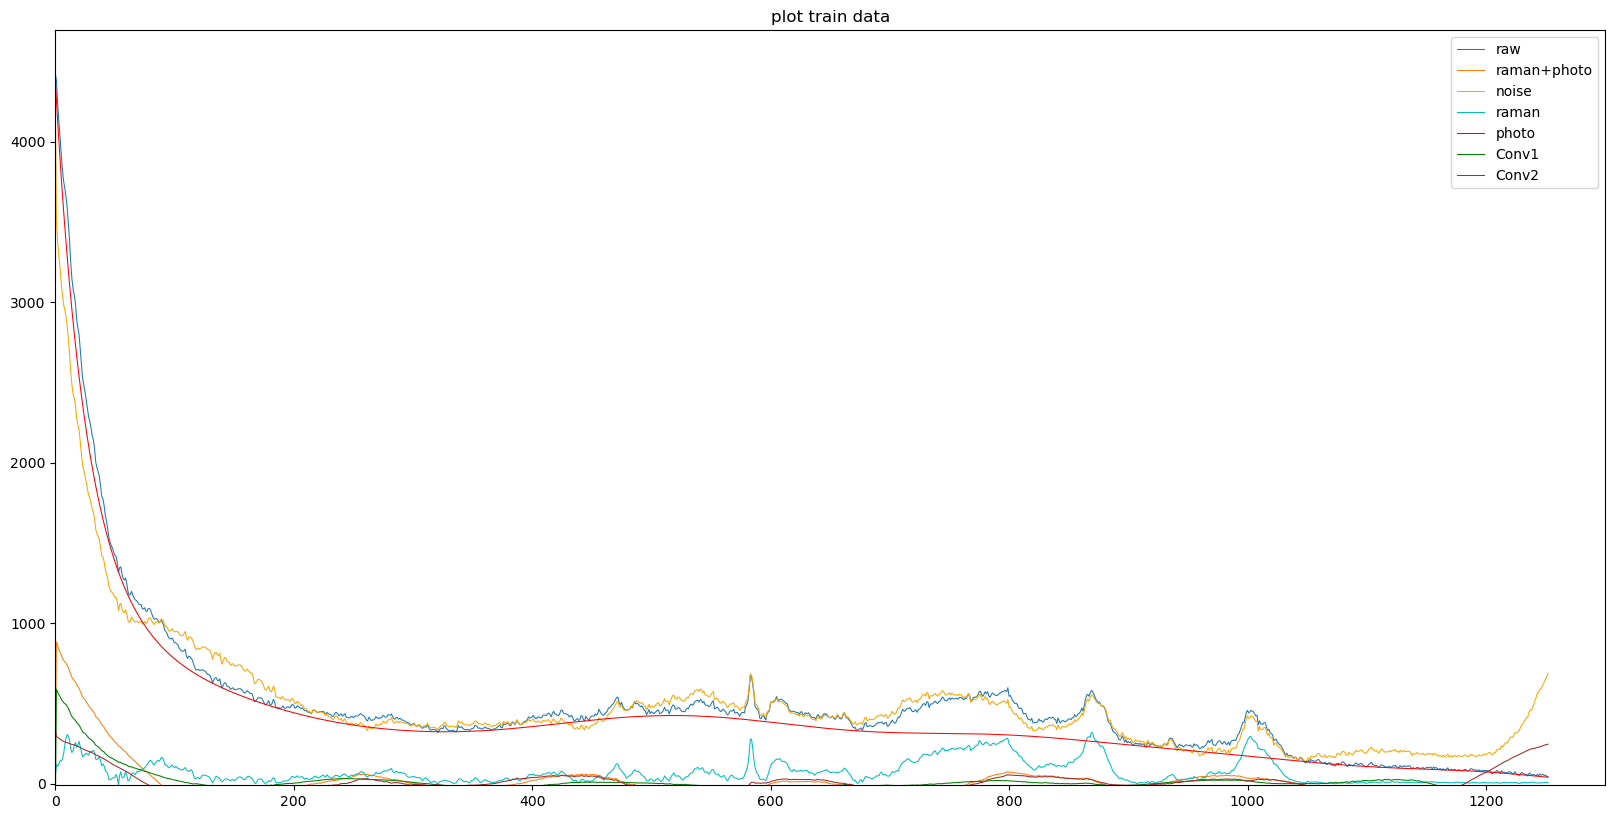

  2022-12-12 12:53:14|     0/ 2696| bits: 1.037931


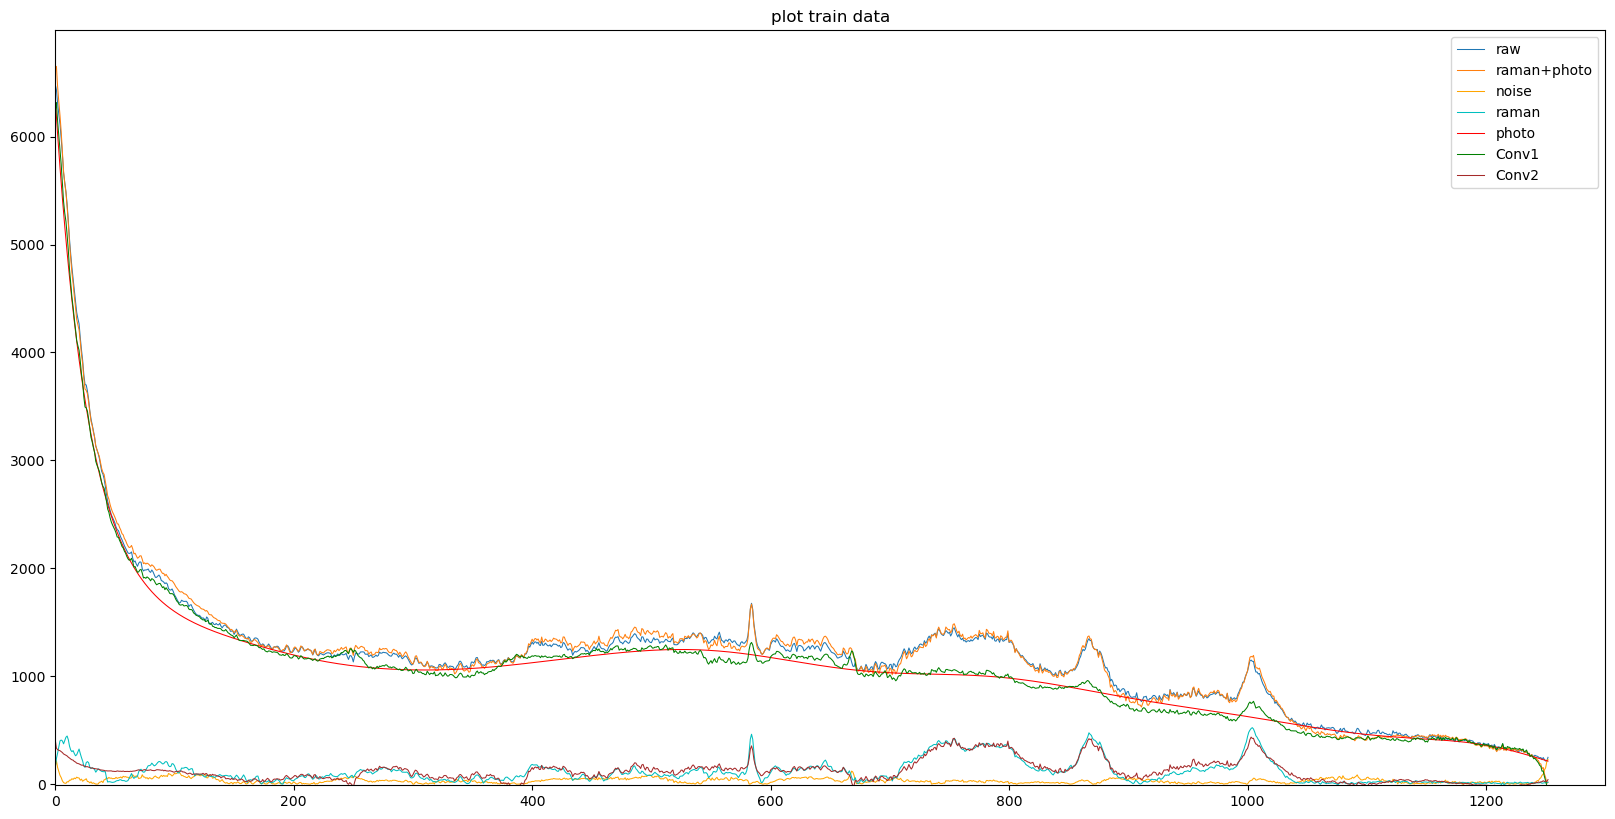

  2022-12-12 12:53:21|   500/ 2696| bits: 0.005984


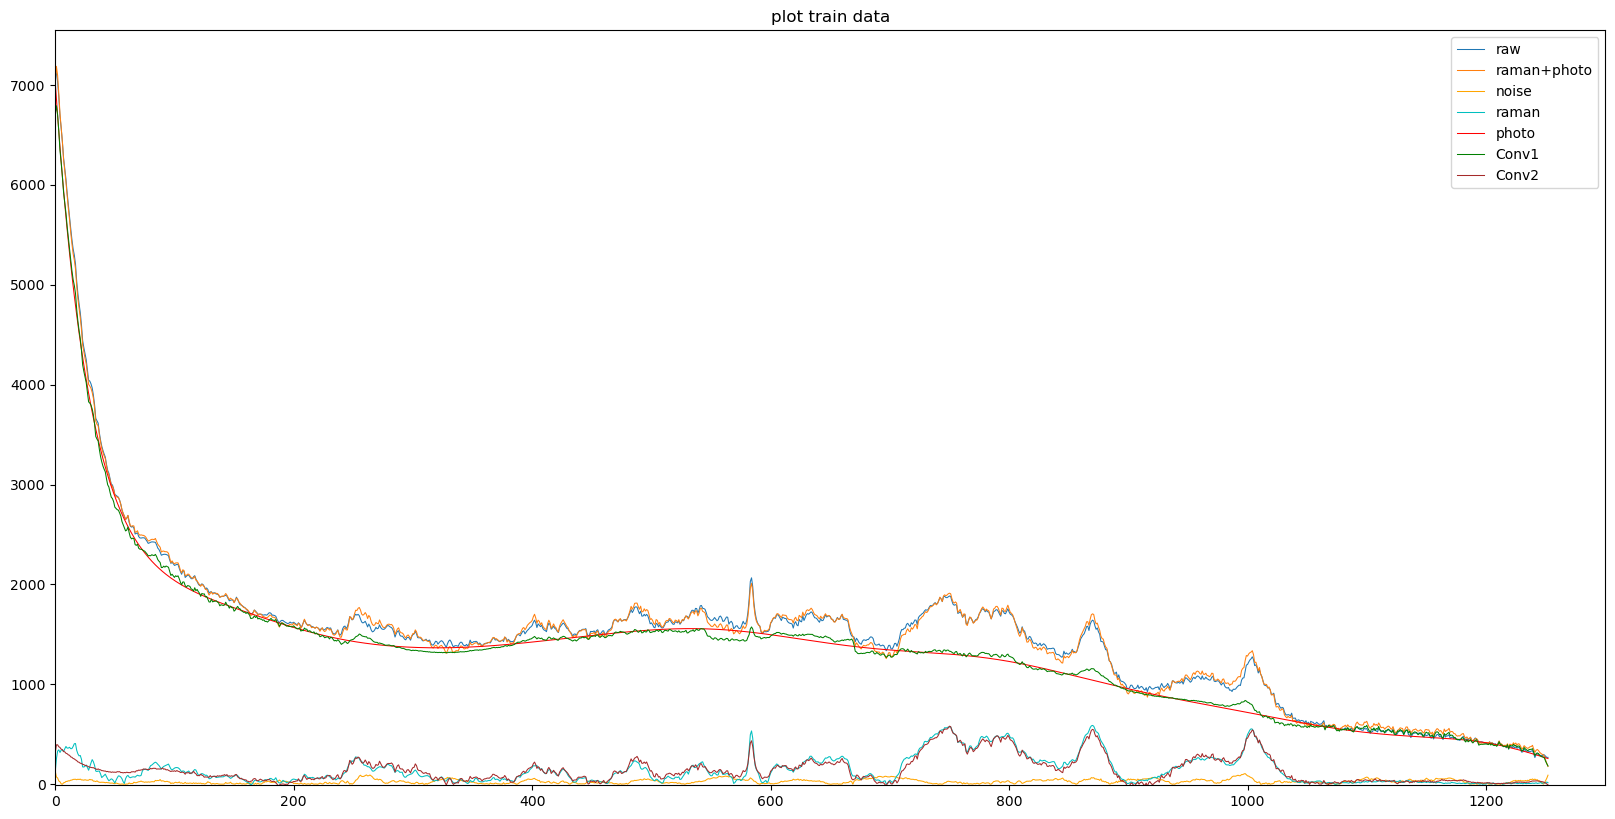

  2022-12-12 12:53:28|  1000/ 2696| bits: 0.002139


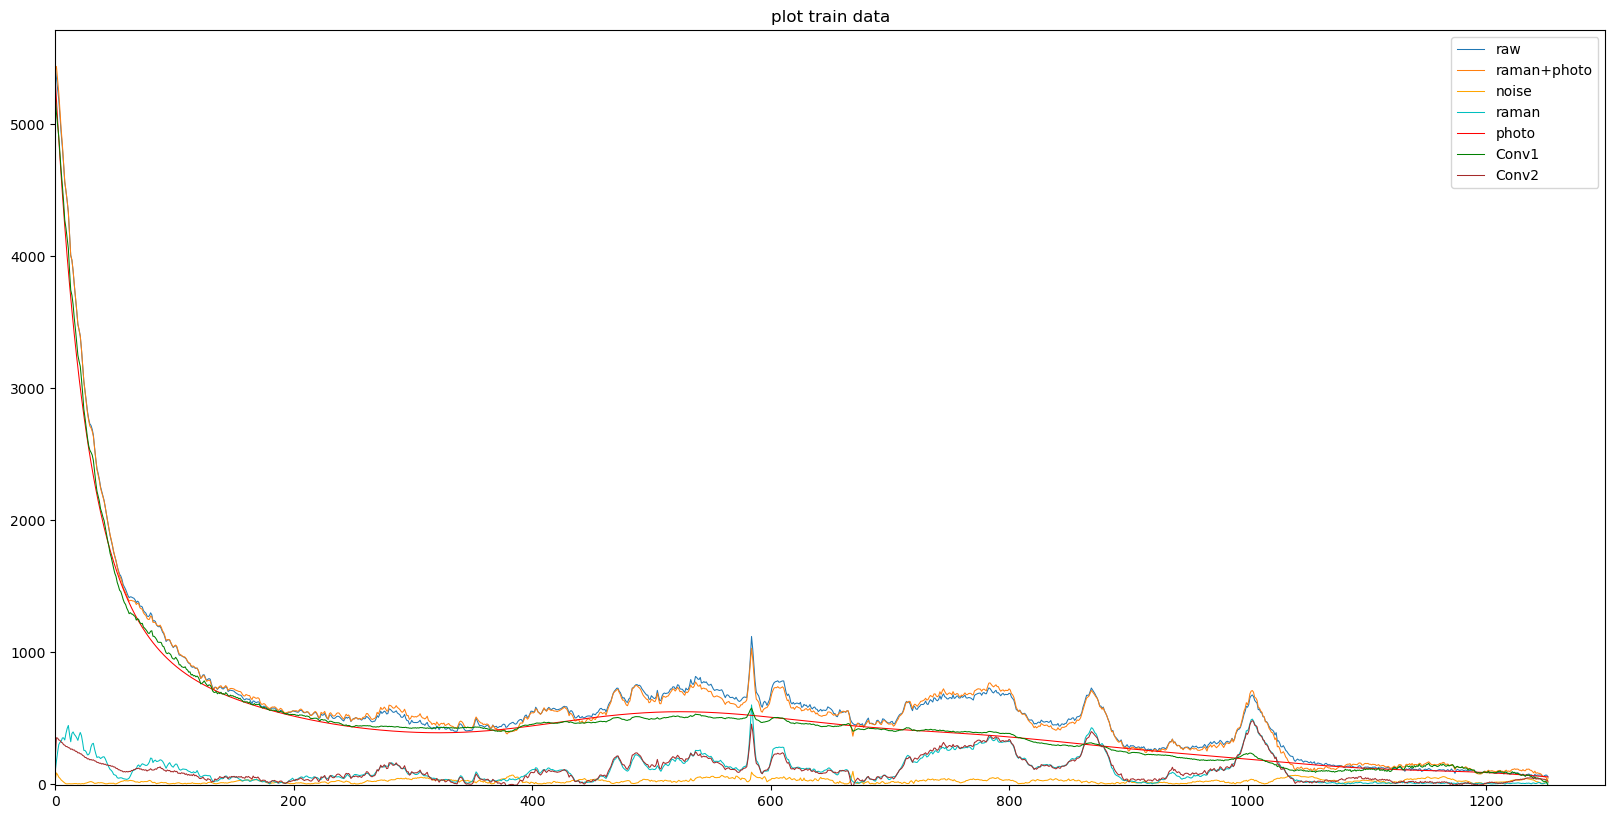

  2022-12-12 12:53:34|  1500/ 2696| bits: 0.001568


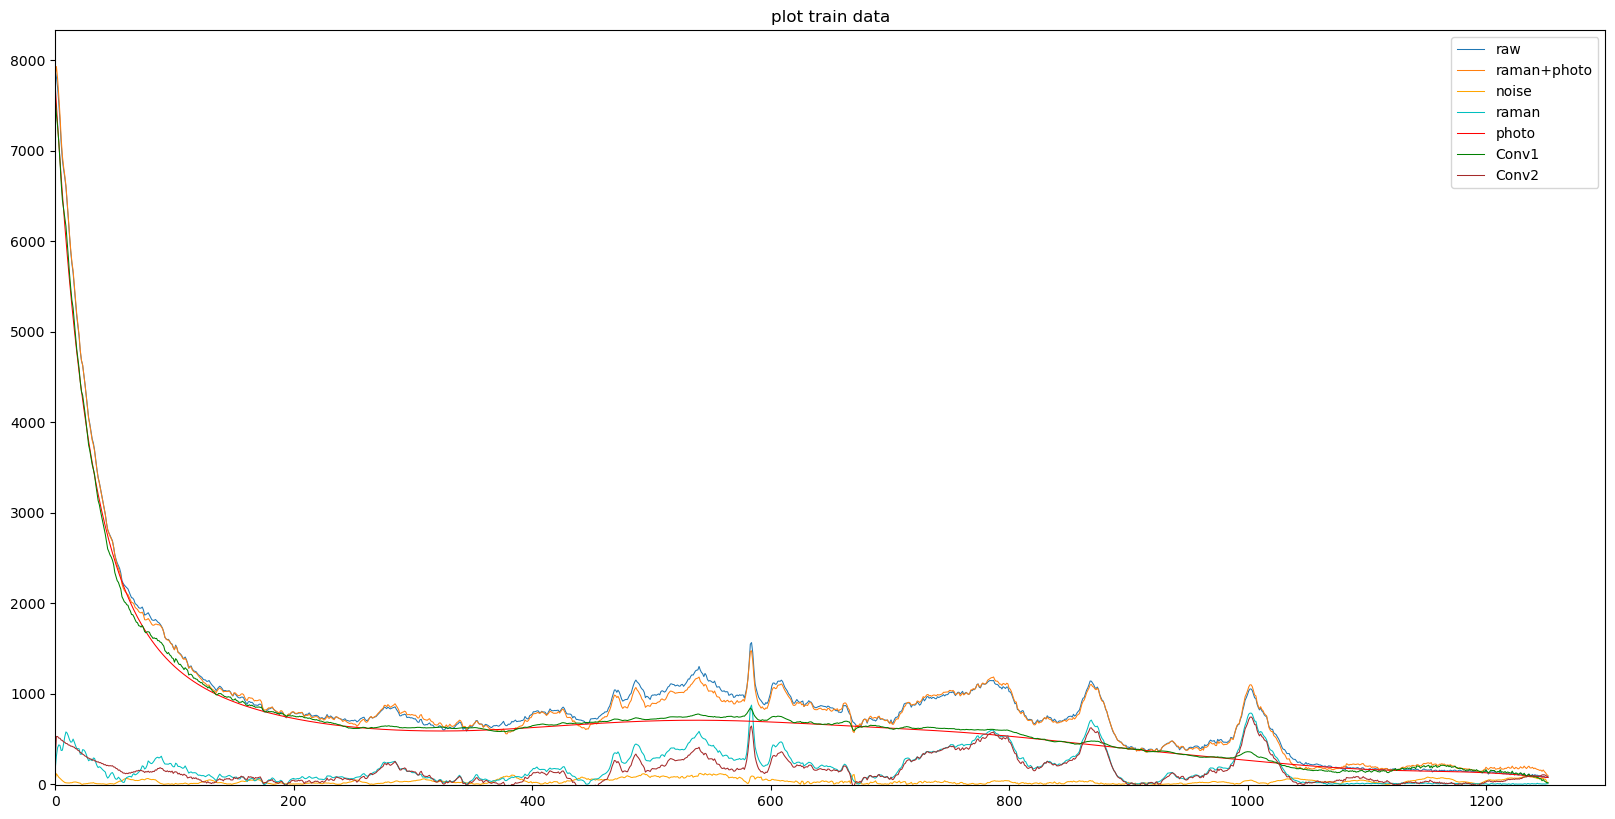

  2022-12-12 12:53:41|  2000/ 2696| bits: 0.001125


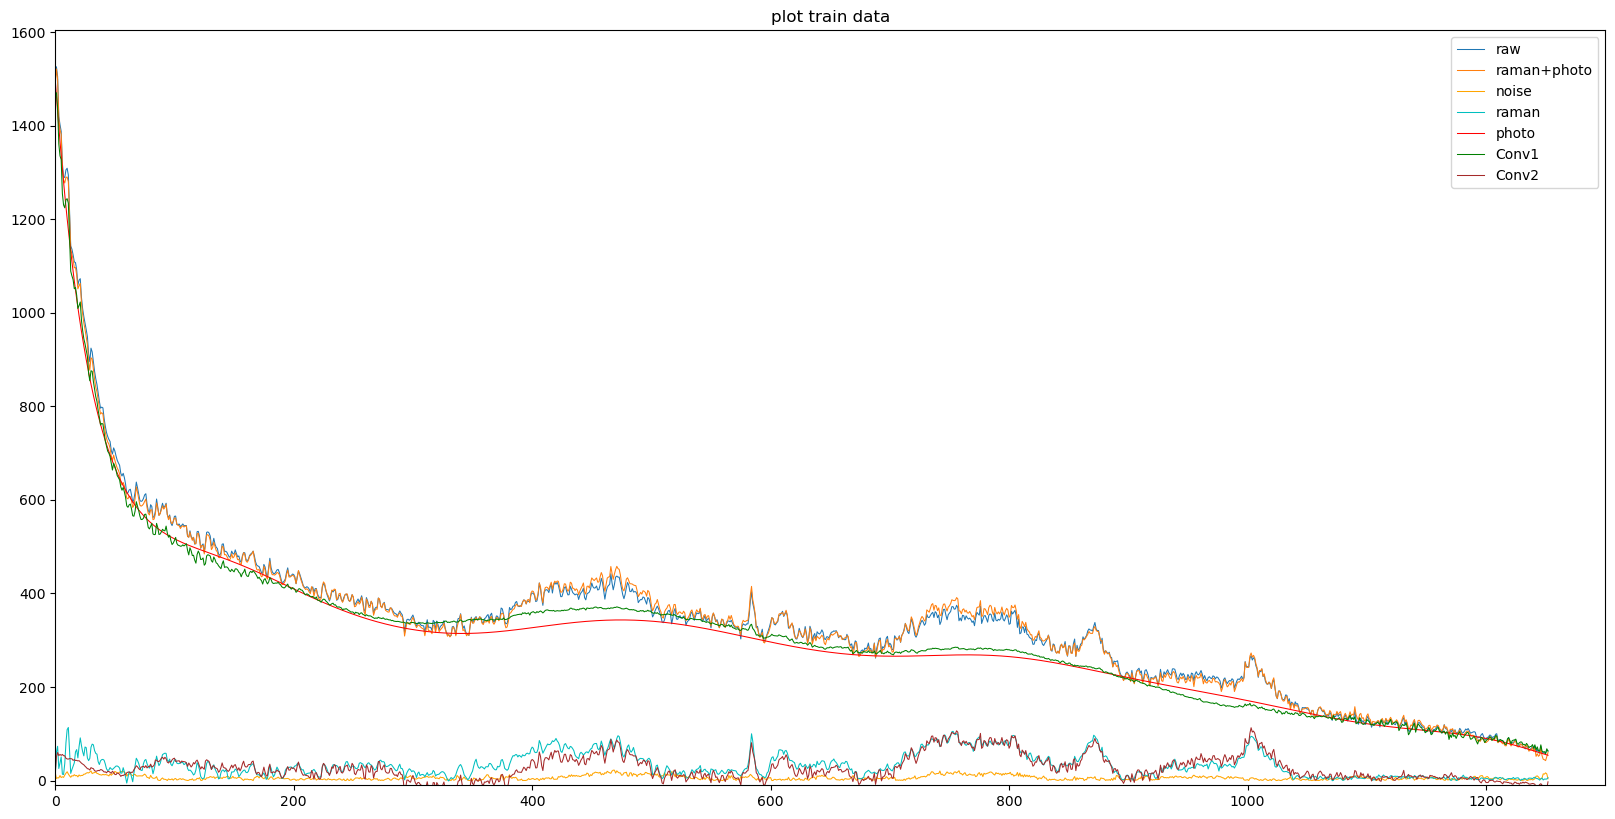

  2022-12-12 12:53:47|  2500/ 2696| bits: 0.000928
Elapsed time: 0h 0m 35s


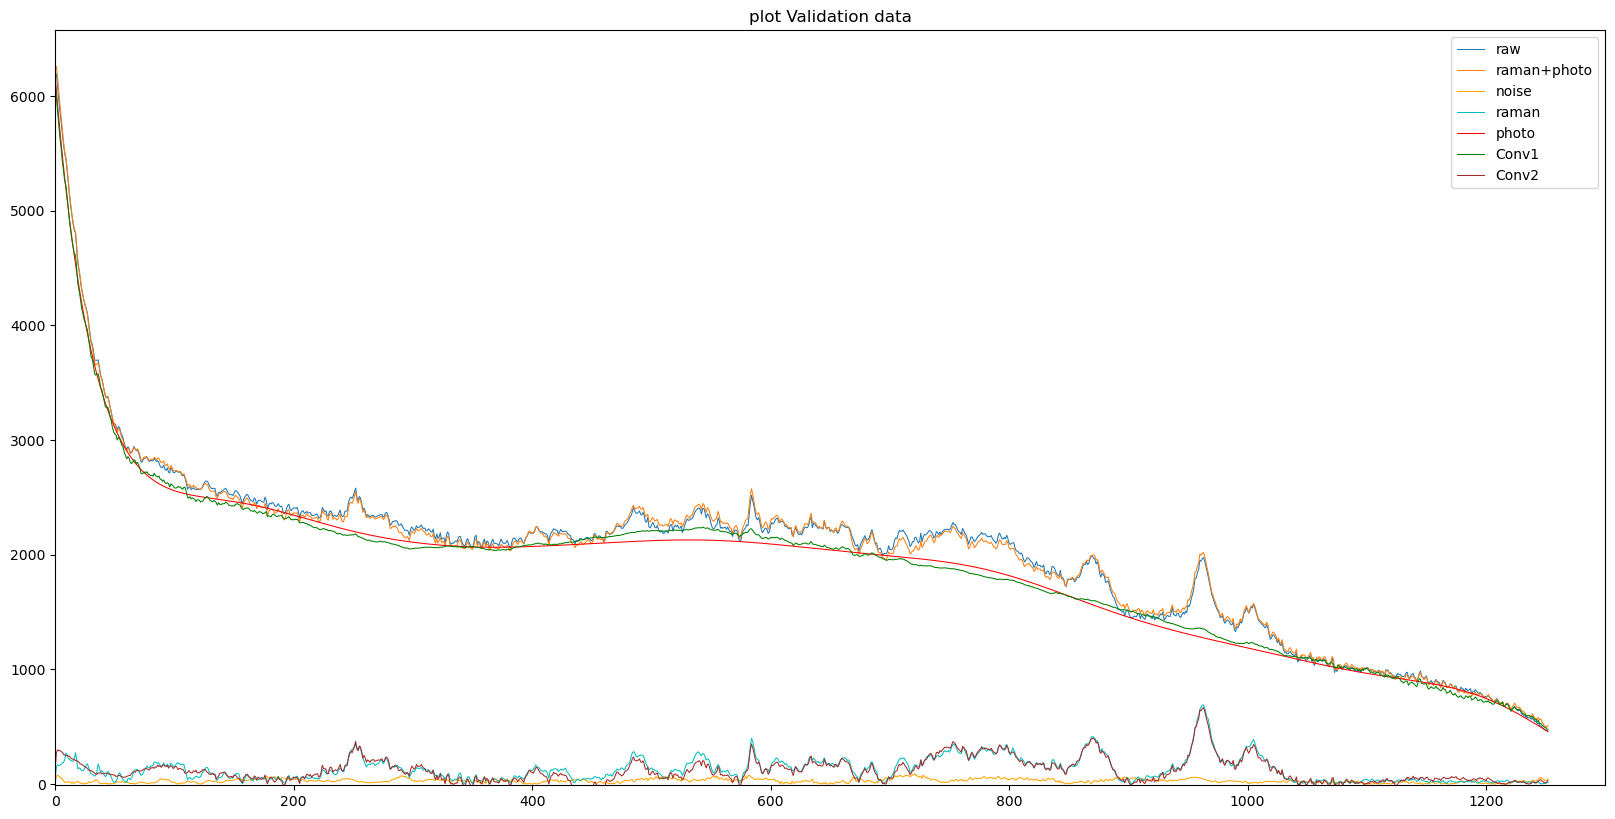

  2022-12-12 12:53:49|     0/  293| bits: 0.000887
Validation average loss: 0.0011276521254330873
--------------------------------------------------
Epoch   1/ 52


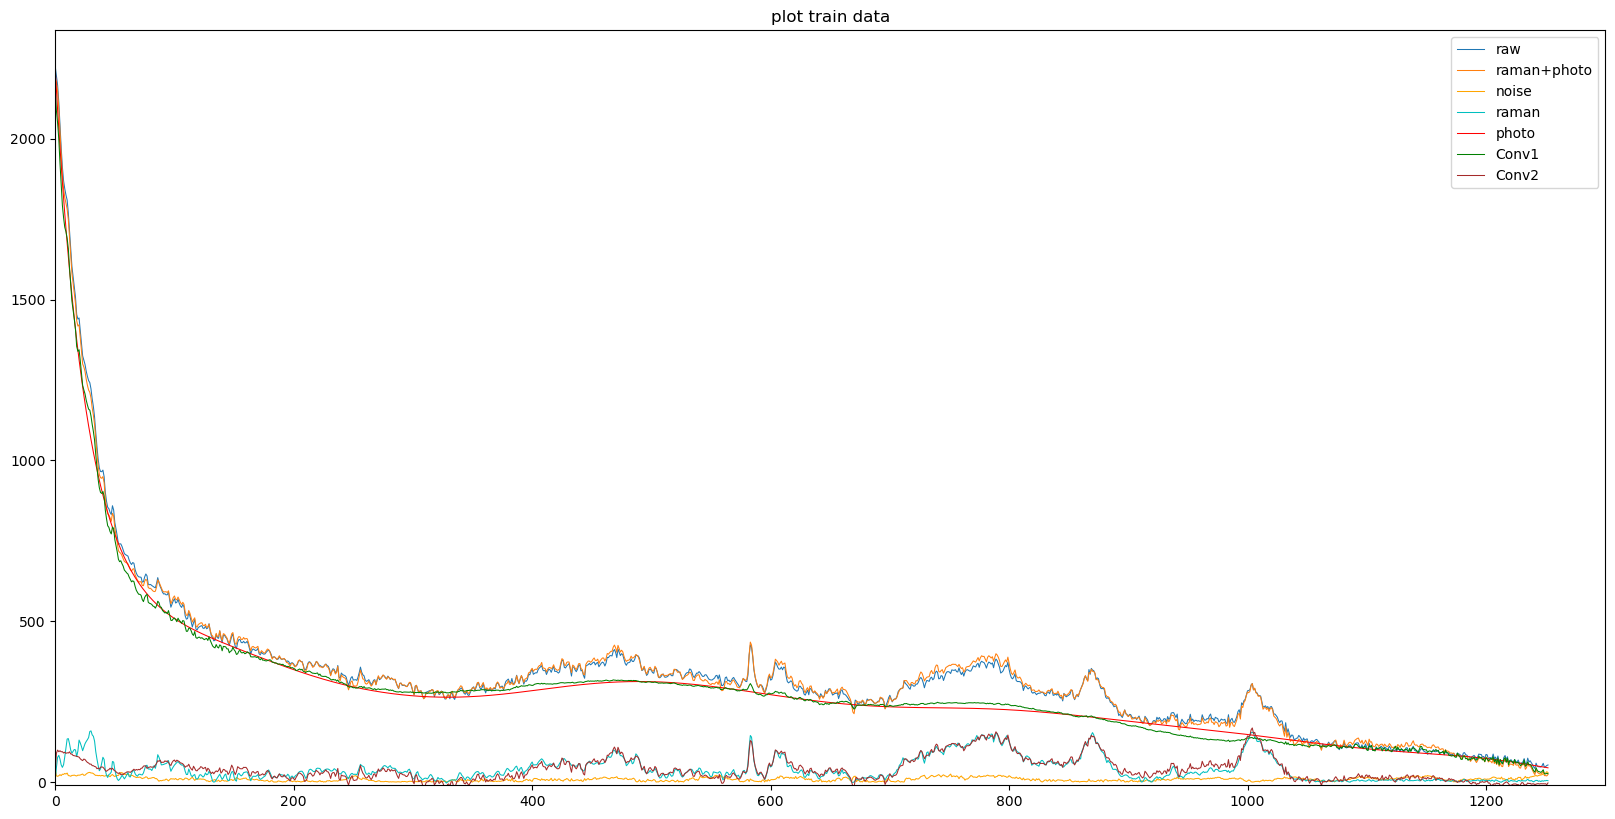

  2022-12-12 12:53:51|     0/ 2696| bits: 0.001247


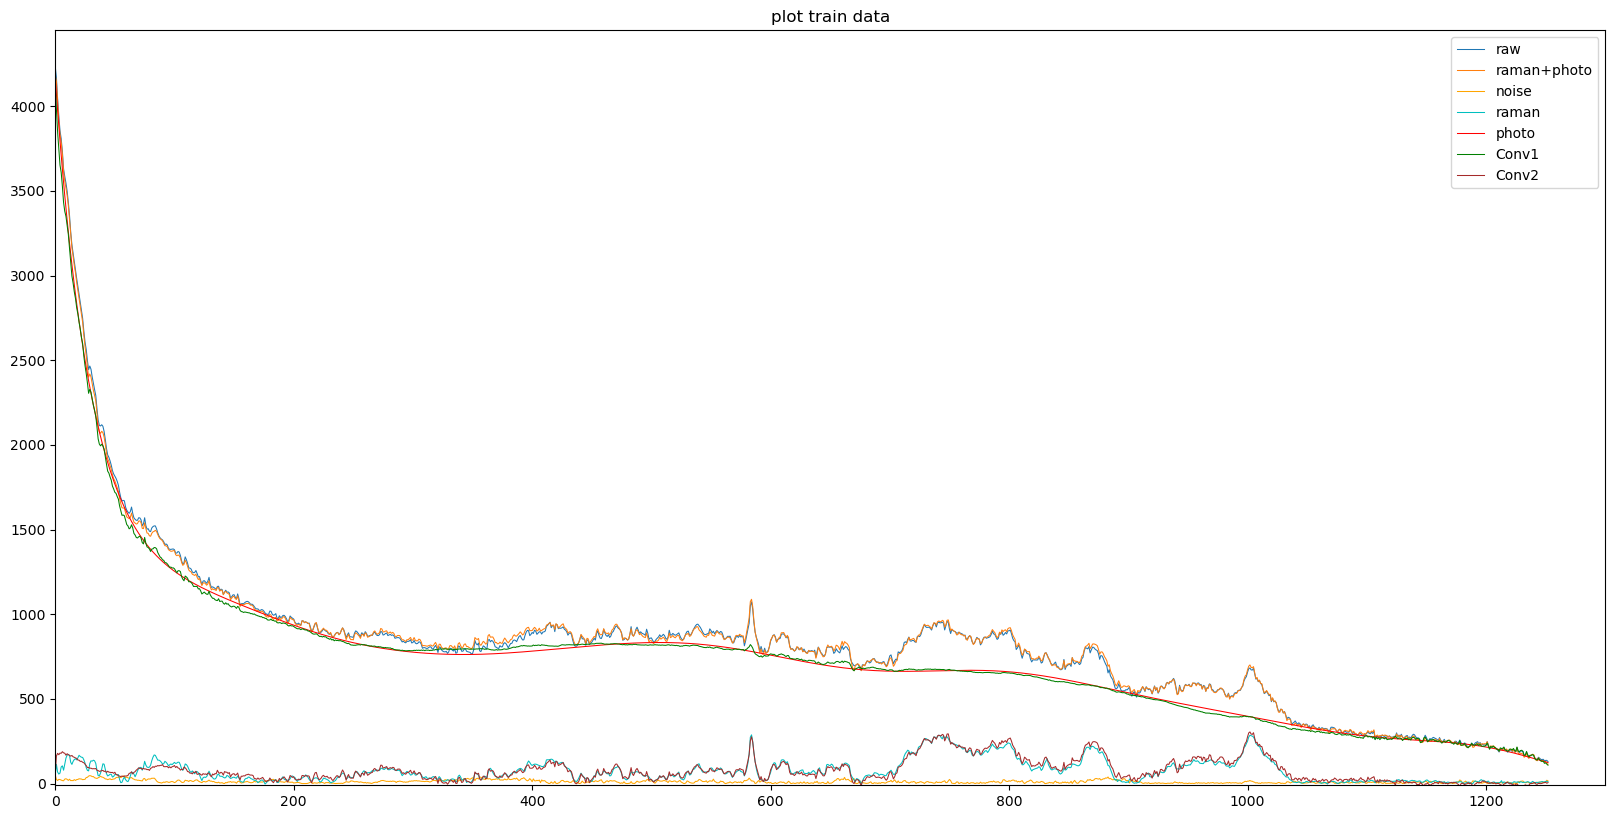

  2022-12-12 12:53:58|   500/ 2696| bits: 0.001172


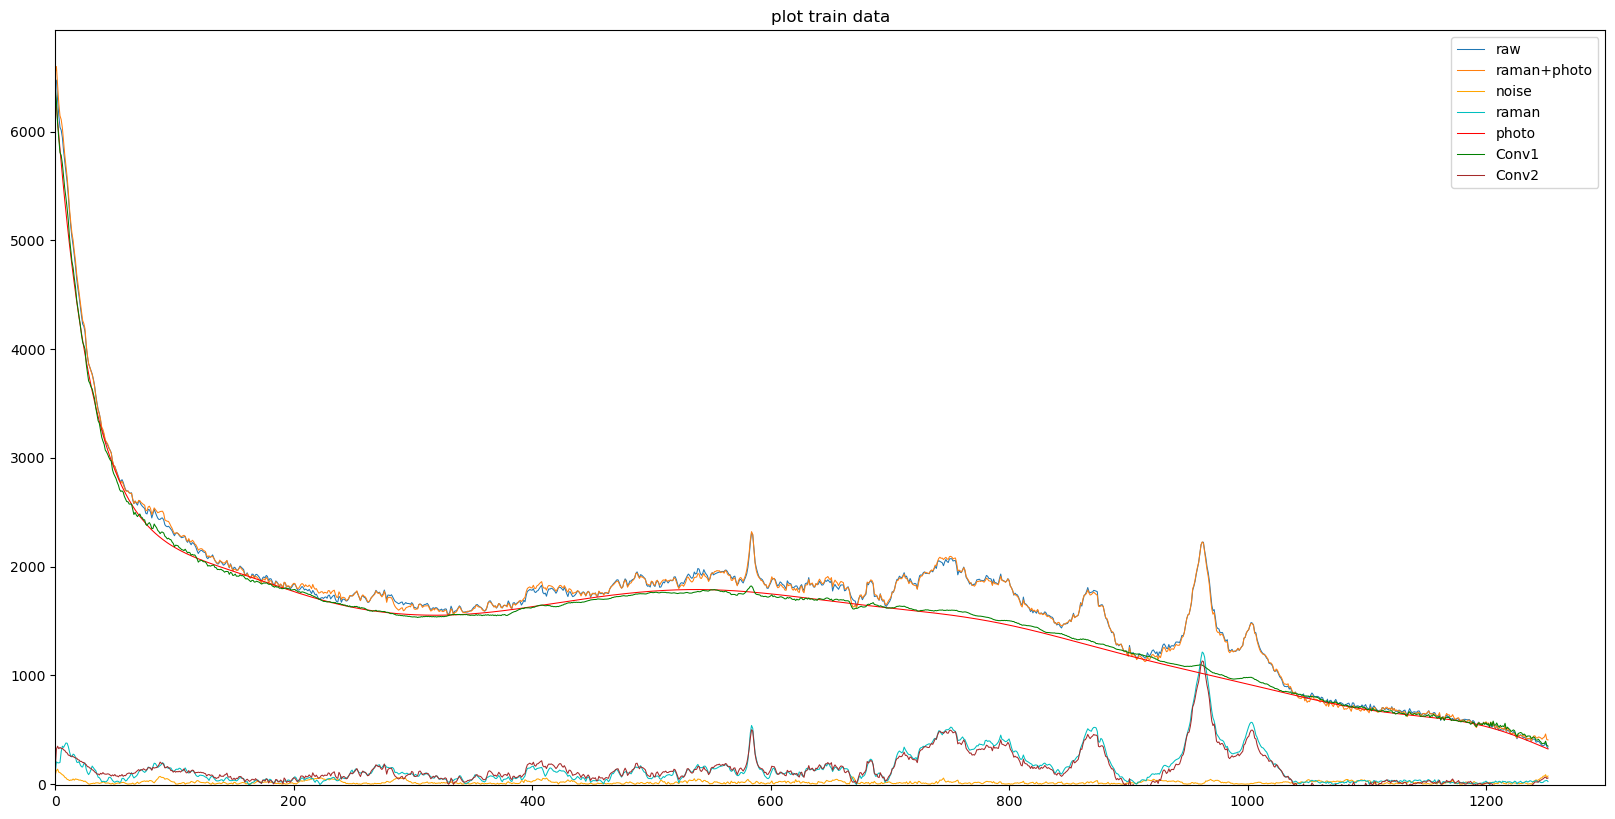

  2022-12-12 12:54:05|  1000/ 2696| bits: 0.001015


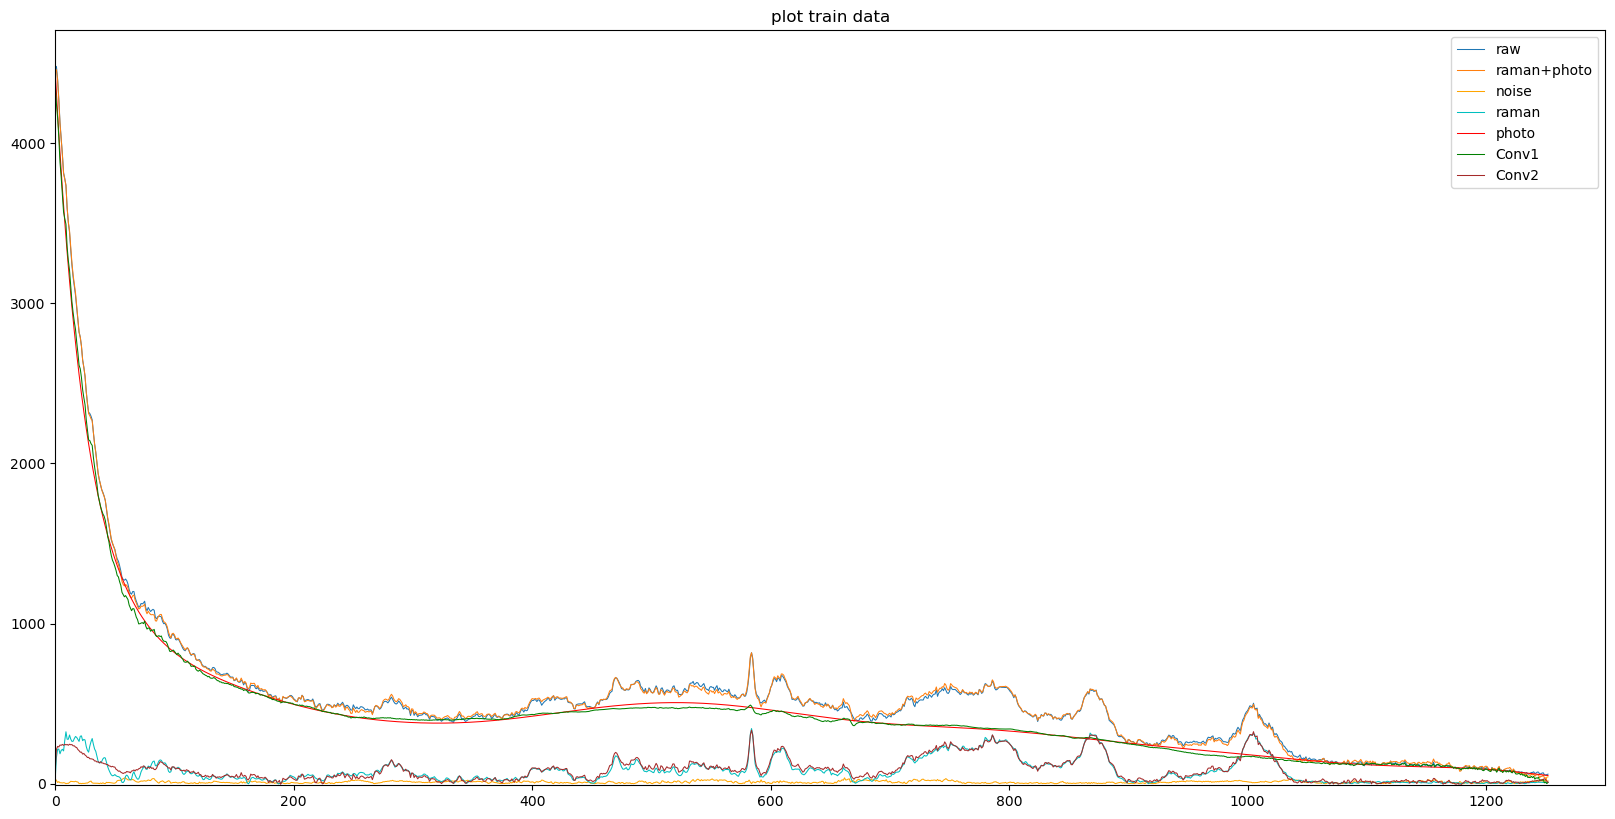

  2022-12-12 12:54:12|  1500/ 2696| bits: 0.000892


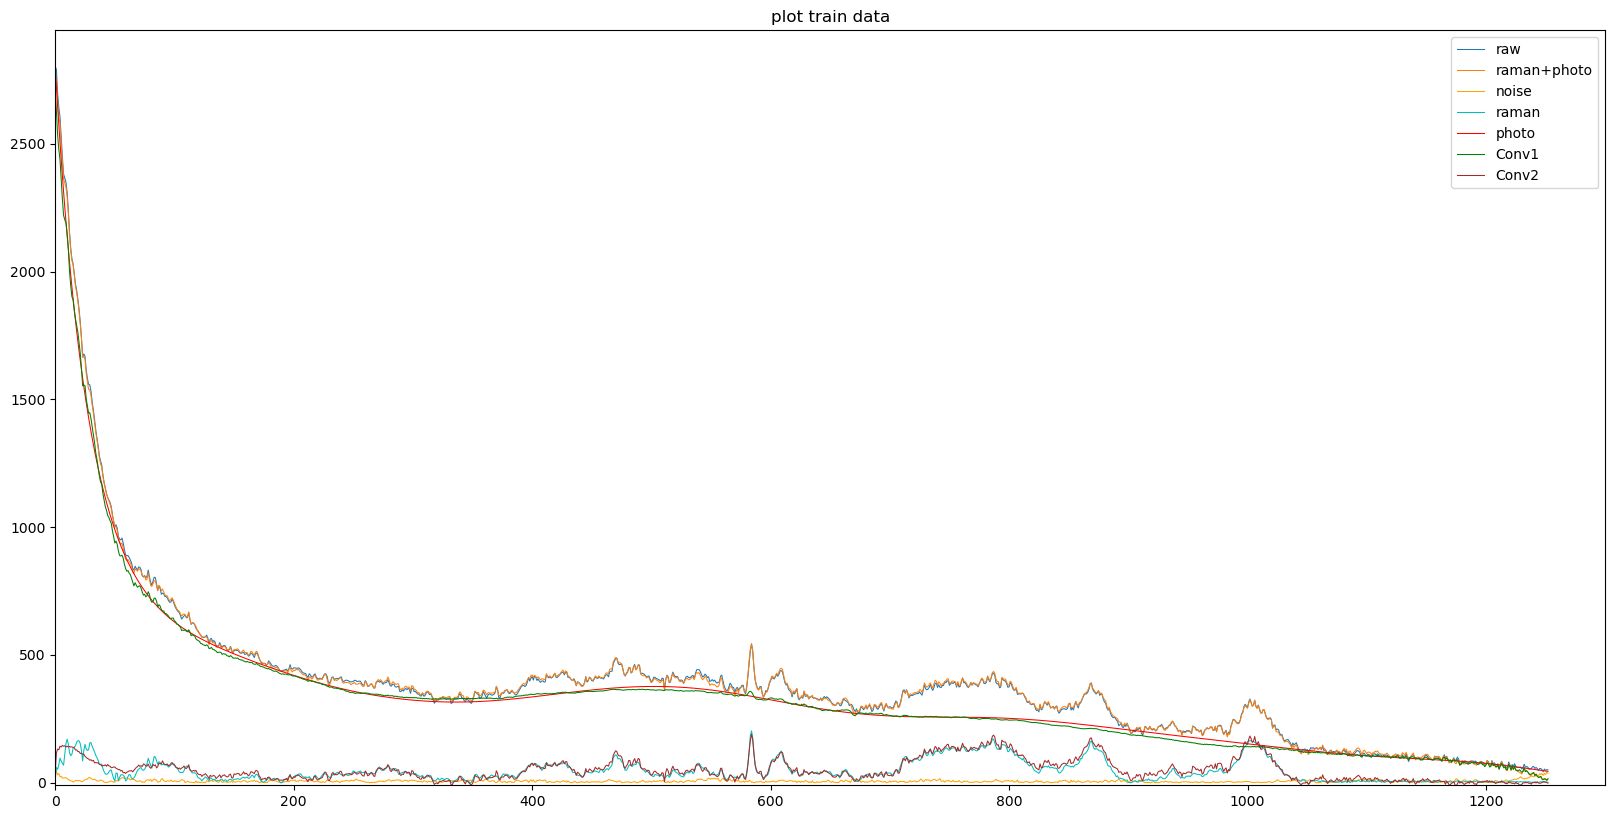

  2022-12-12 12:54:18|  2000/ 2696| bits: 0.000996


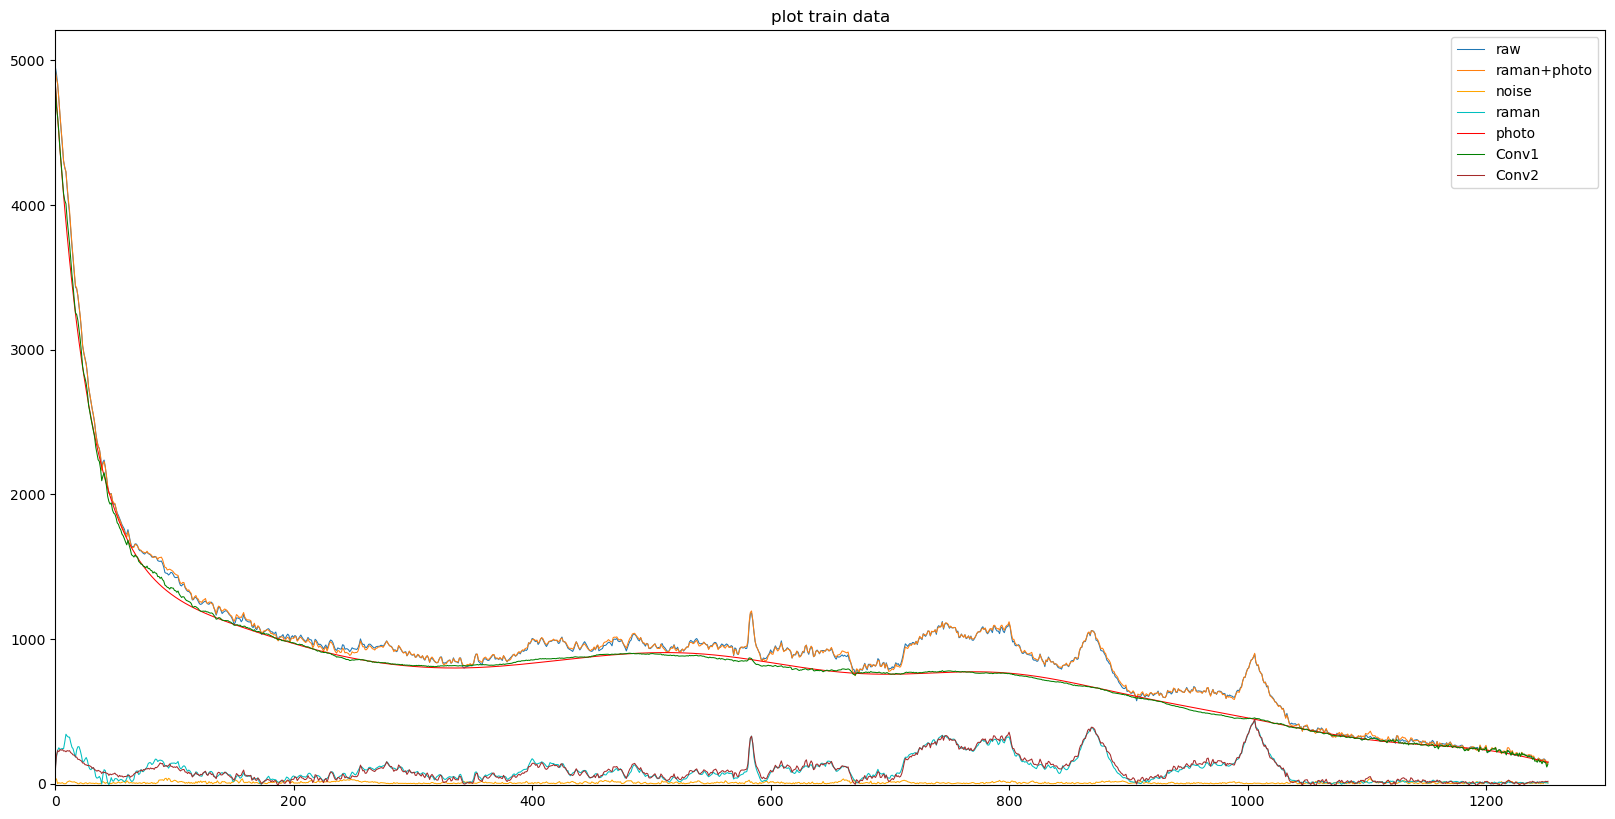

  2022-12-12 12:54:25|  2500/ 2696| bits: 0.000780
Elapsed time: 0h 0m 35s


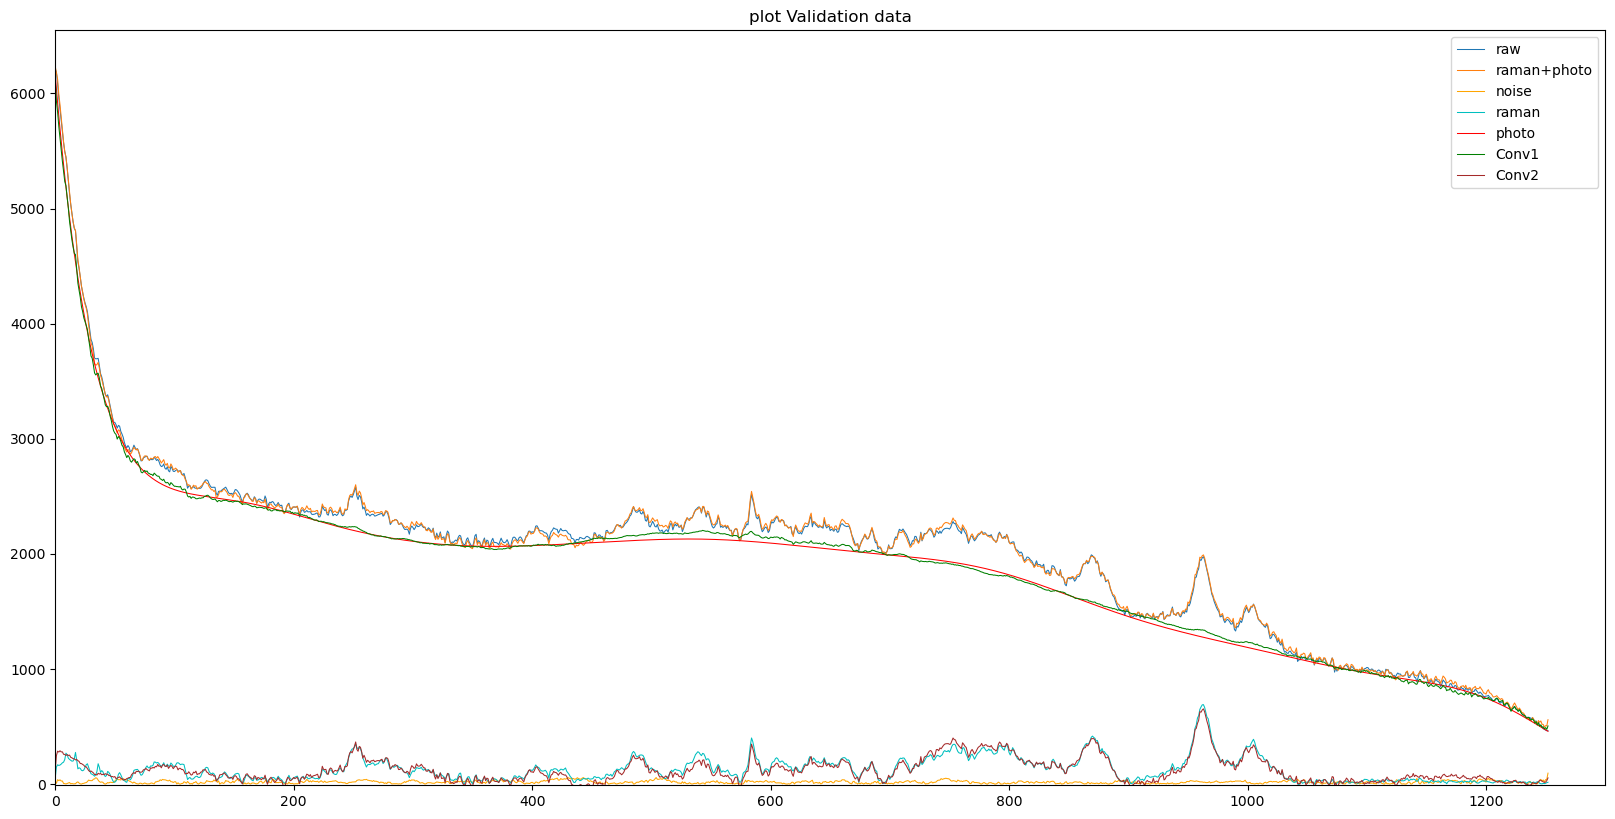

  2022-12-12 12:54:27|     0/  293| bits: 0.000670
Validation average loss: 0.0007894818554632366
--------------------------------------------------
Epoch   2/ 52


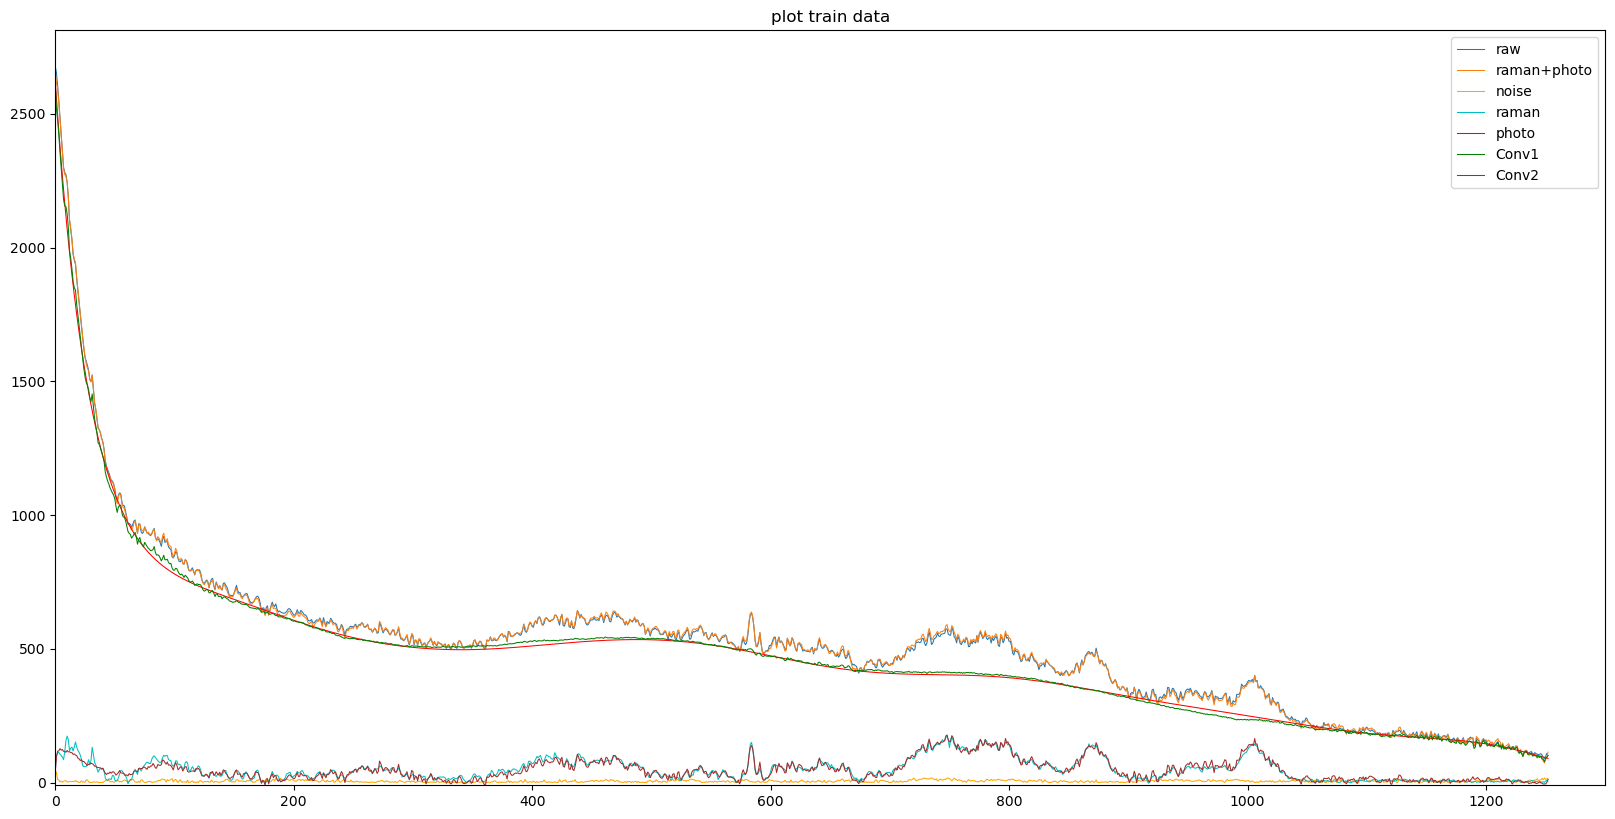

  2022-12-12 12:54:29|     0/ 2696| bits: 0.001049


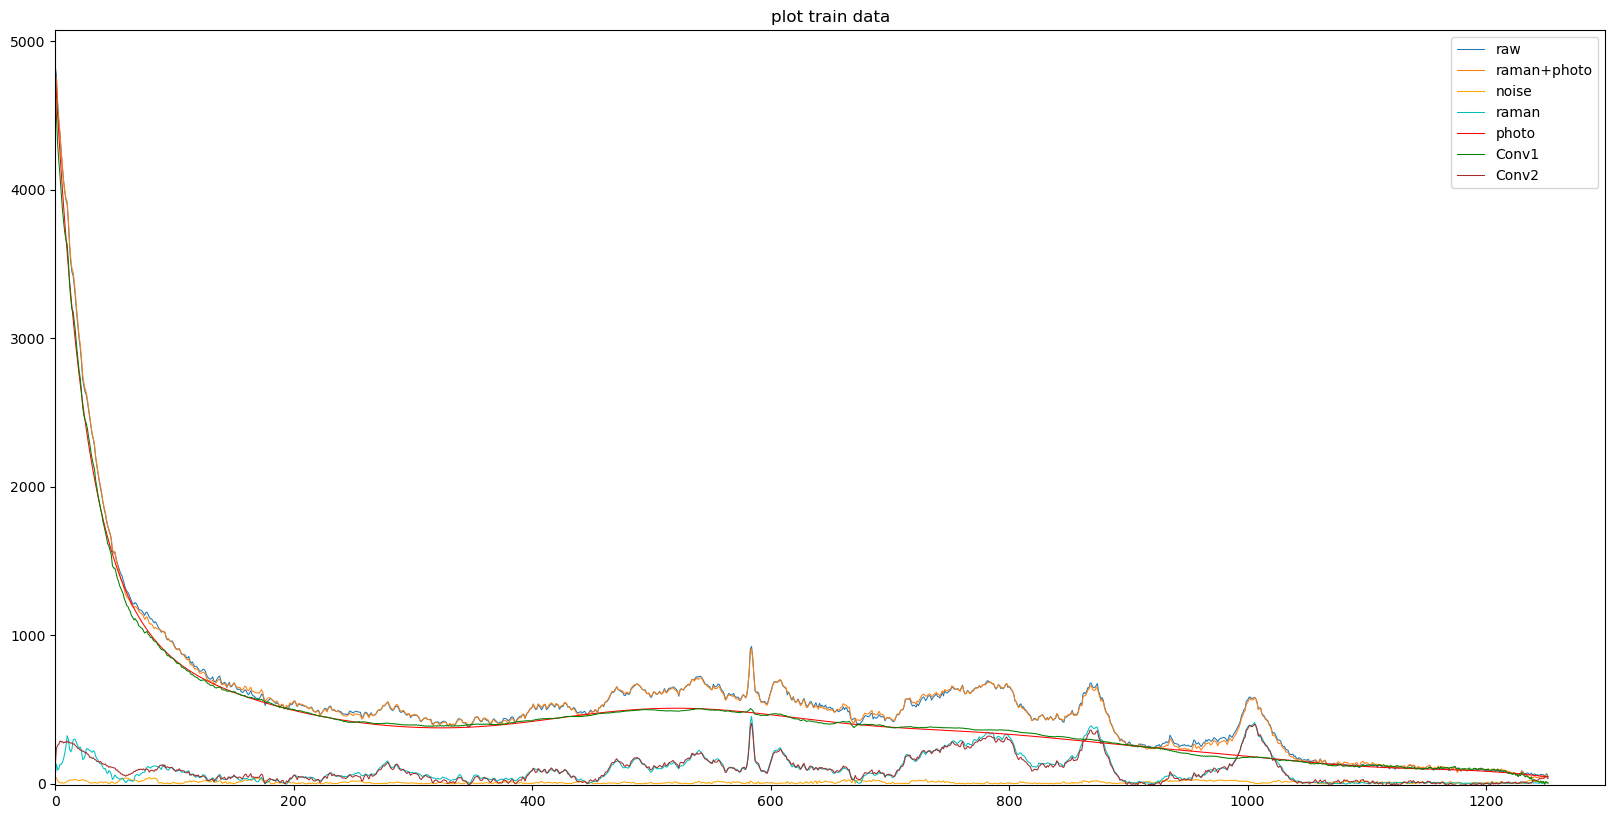

  2022-12-12 12:54:36|   500/ 2696| bits: 0.000813


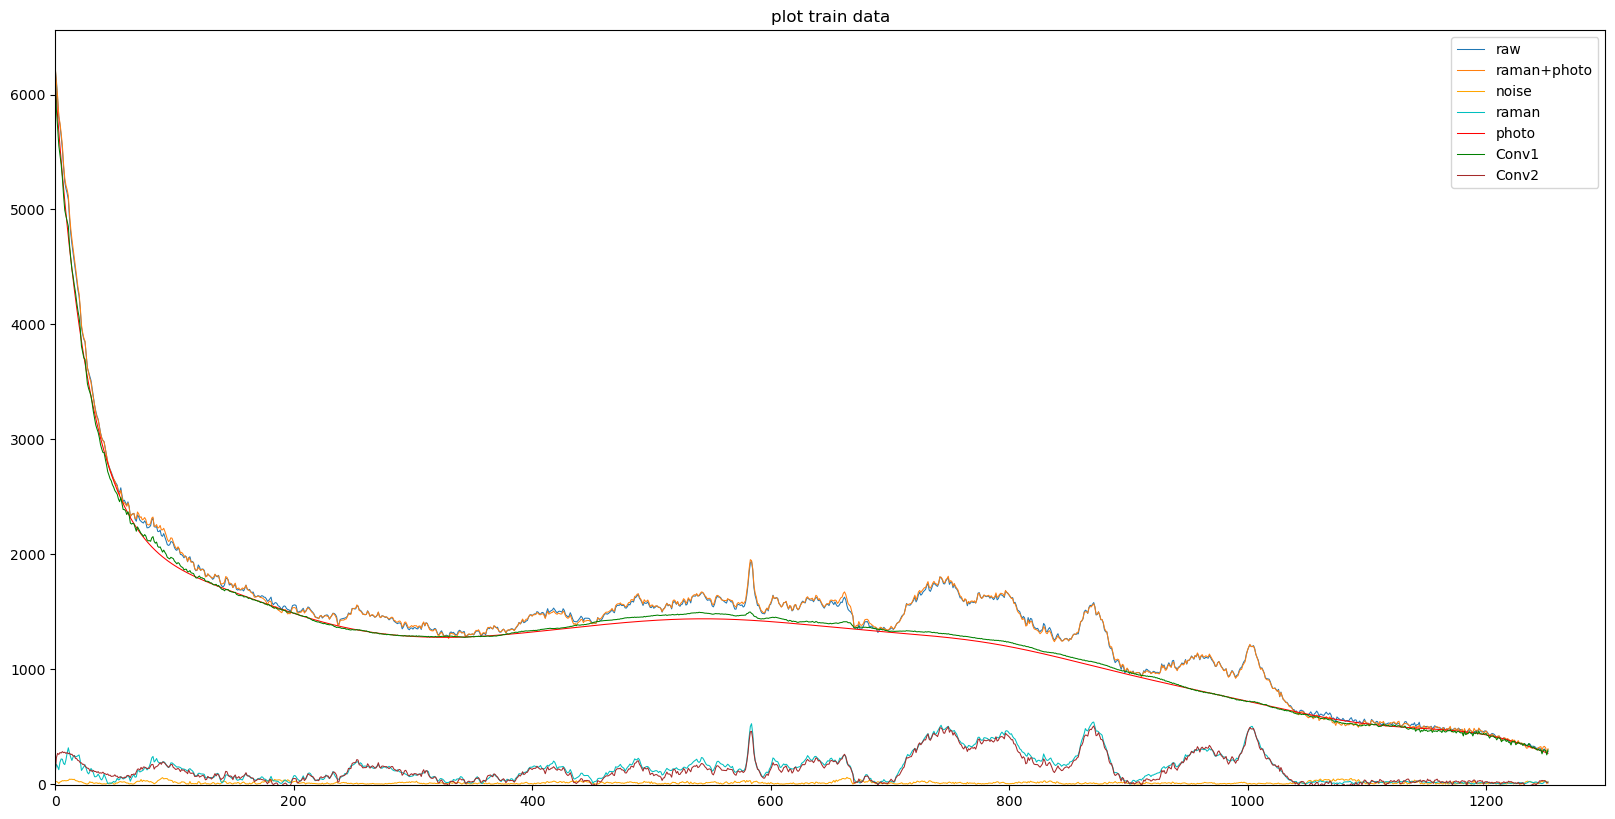

  2022-12-12 12:54:42|  1000/ 2696| bits: 0.000849


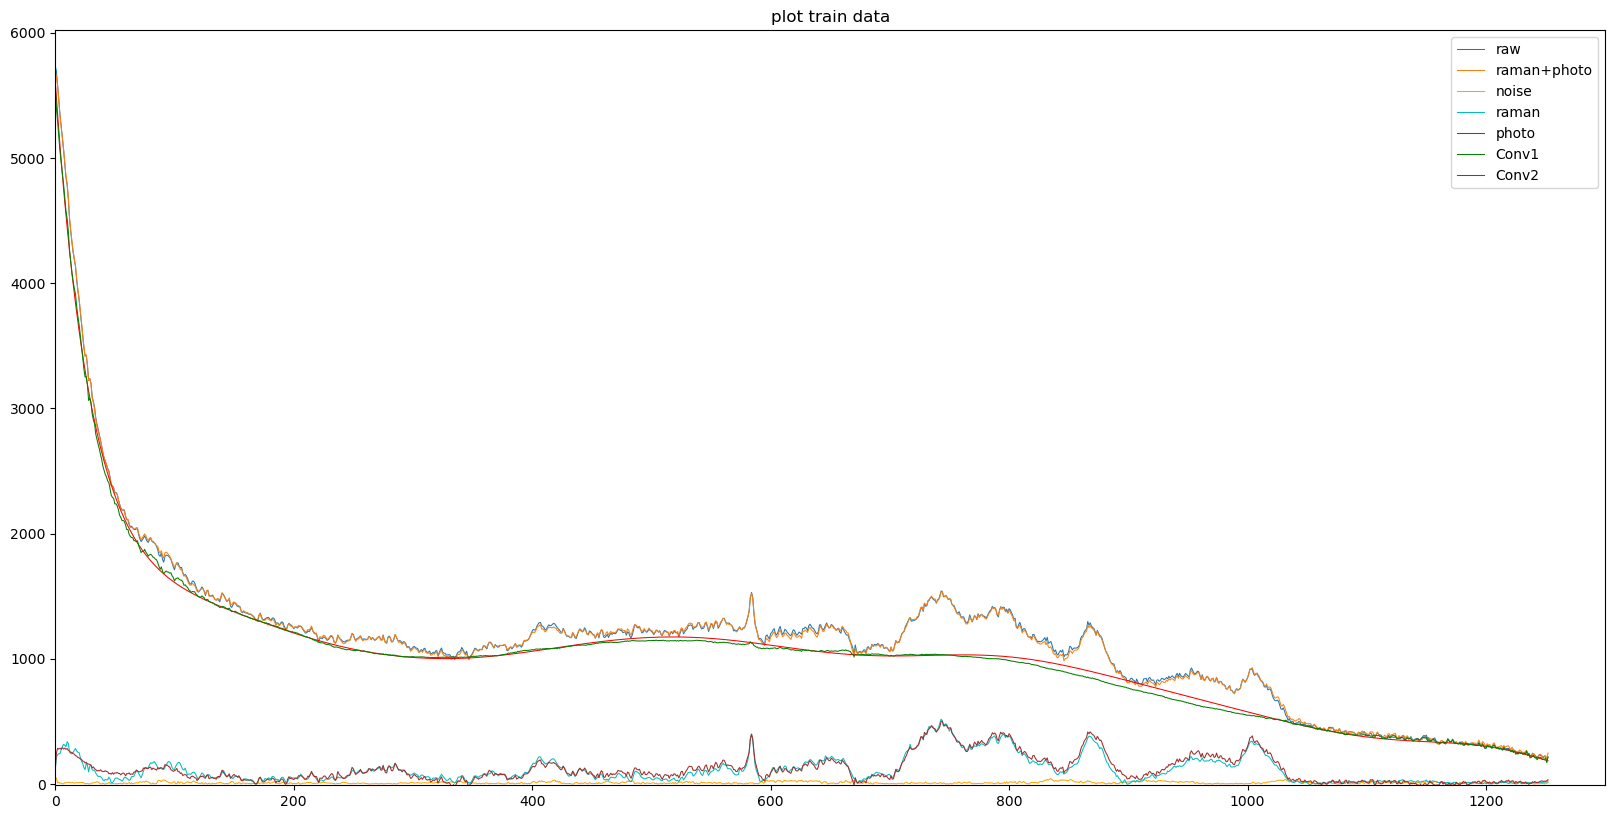

  2022-12-12 12:54:49|  1500/ 2696| bits: 0.000763


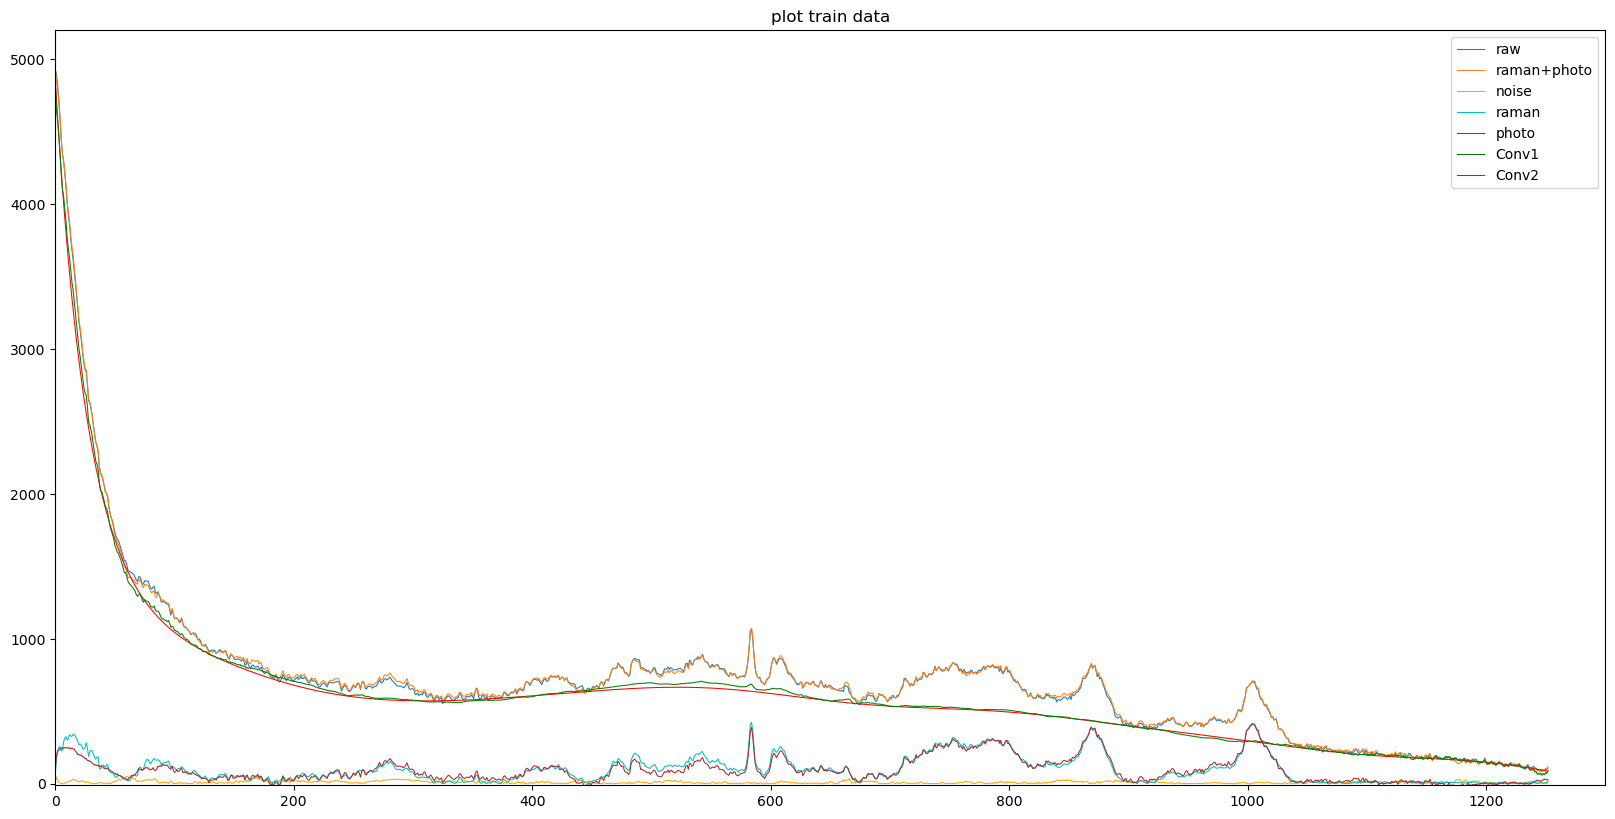

  2022-12-12 12:54:55|  2000/ 2696| bits: 0.000816


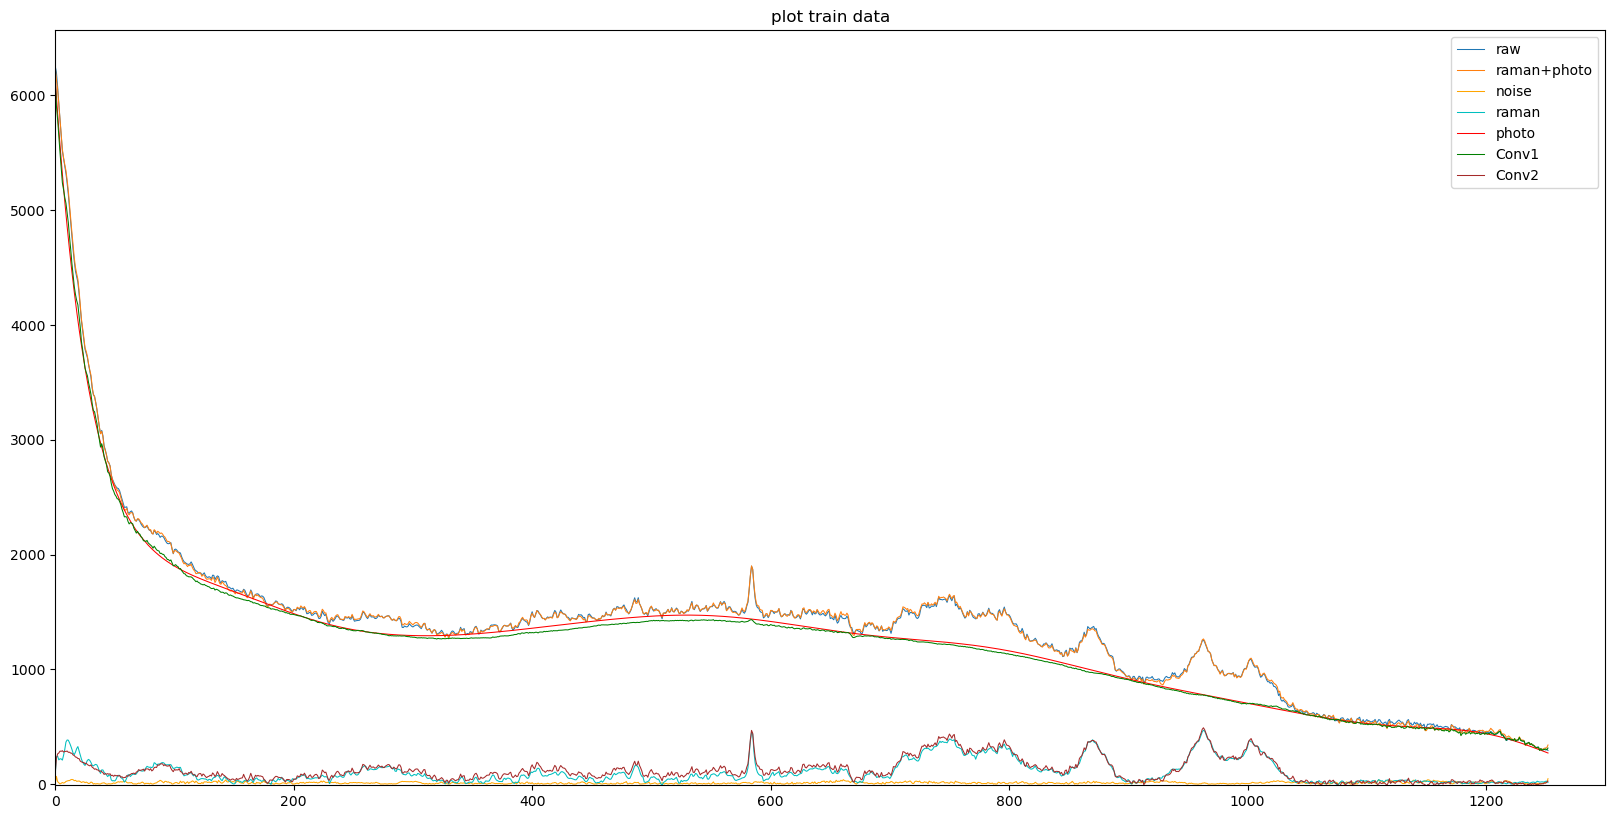

  2022-12-12 12:55:02|  2500/ 2696| bits: 0.000846
Elapsed time: 0h 0m 35s


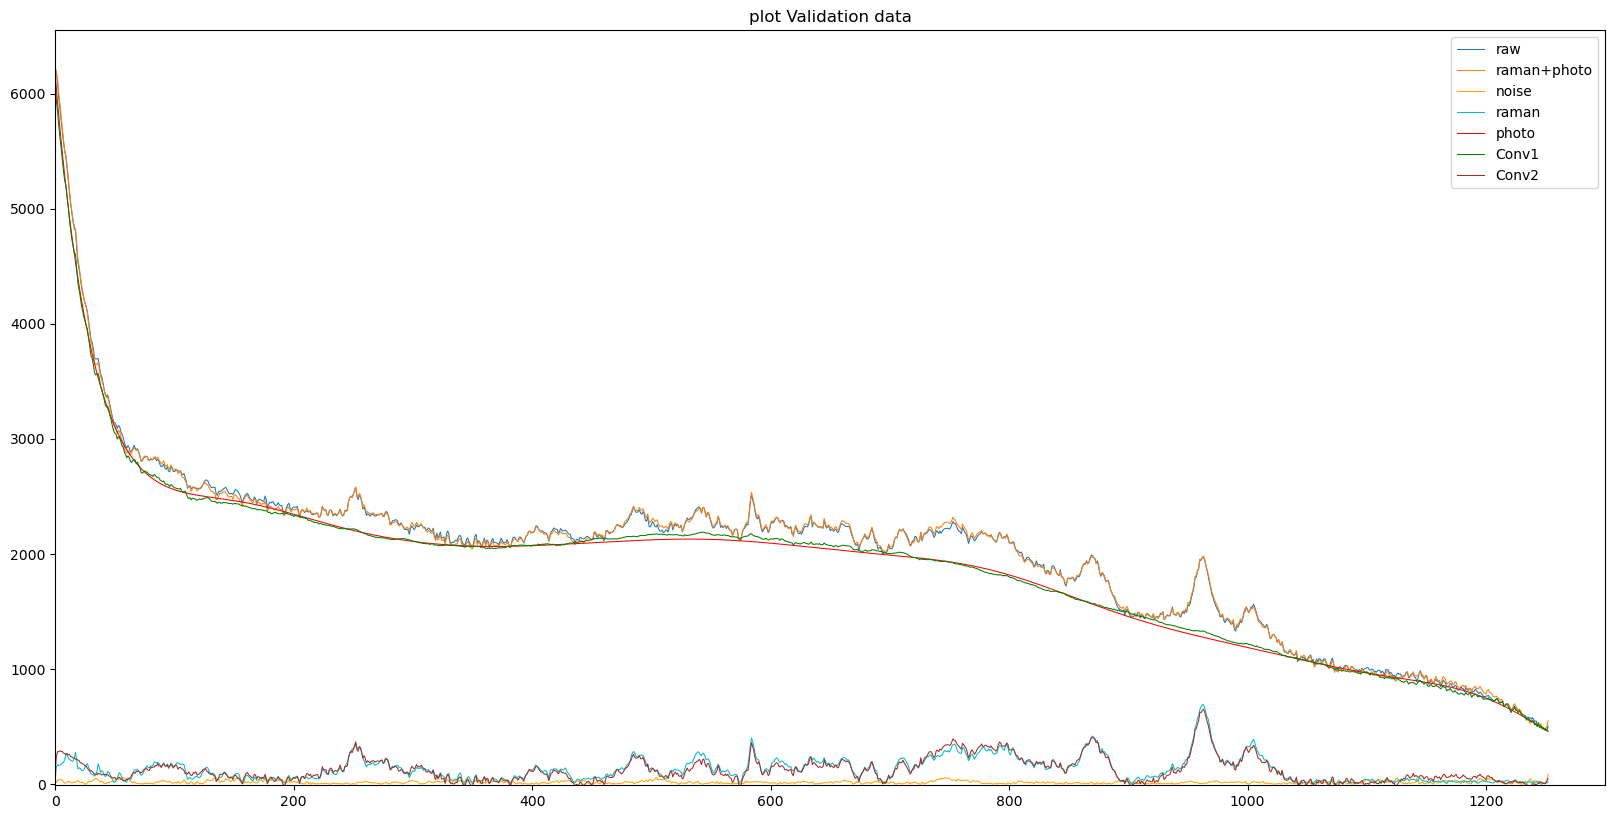

  2022-12-12 12:55:05|     0/  293| bits: 0.000620
Validation average loss: 0.0007597997901029885
--------------------------------------------------
Epoch   3/ 52


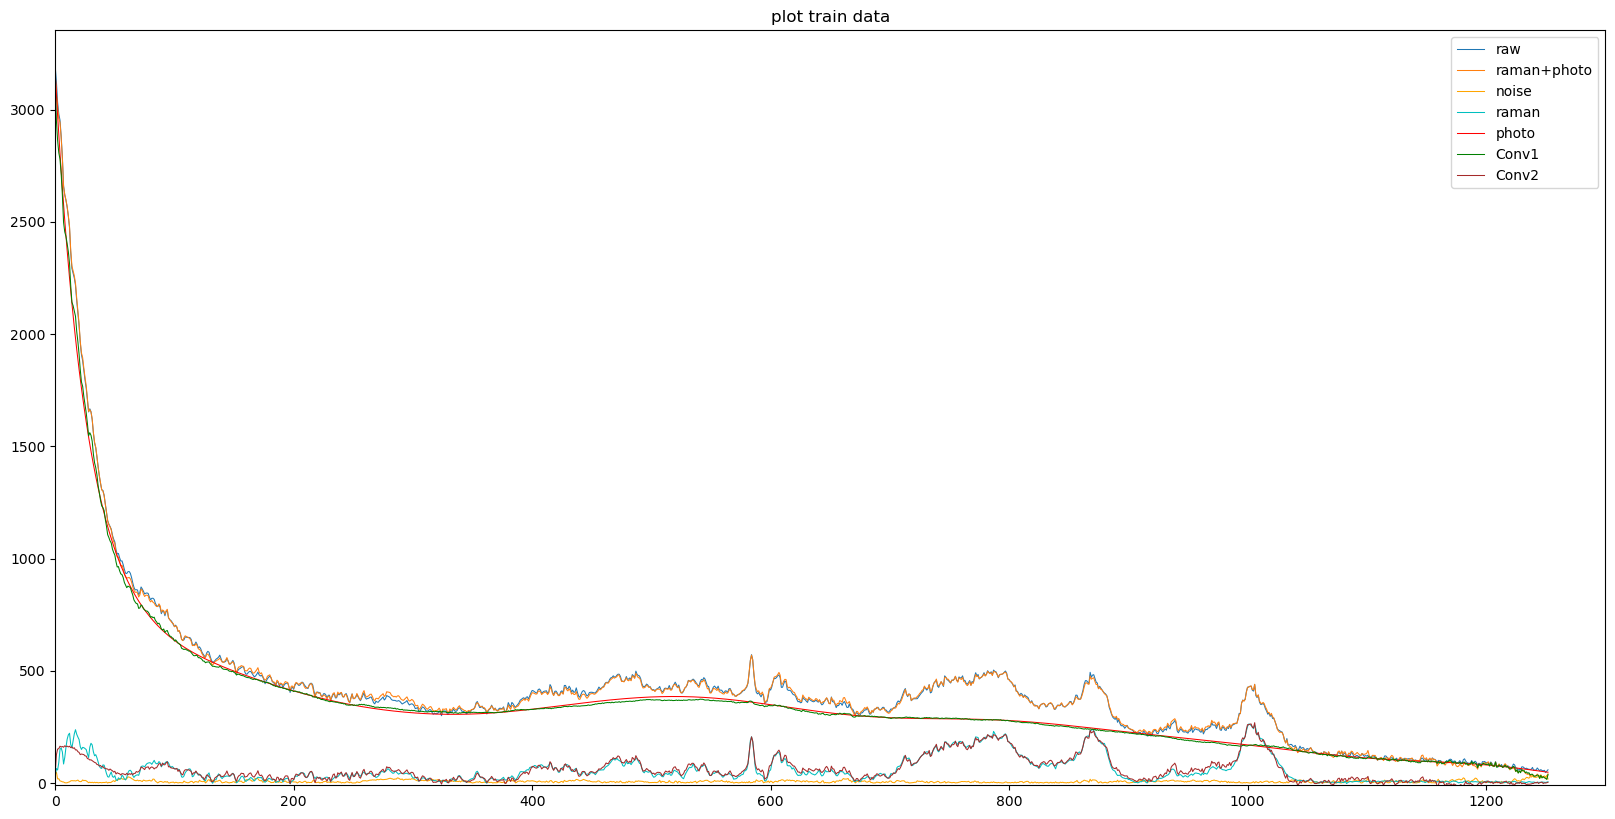

  2022-12-12 12:55:07|     0/ 2696| bits: 0.000873


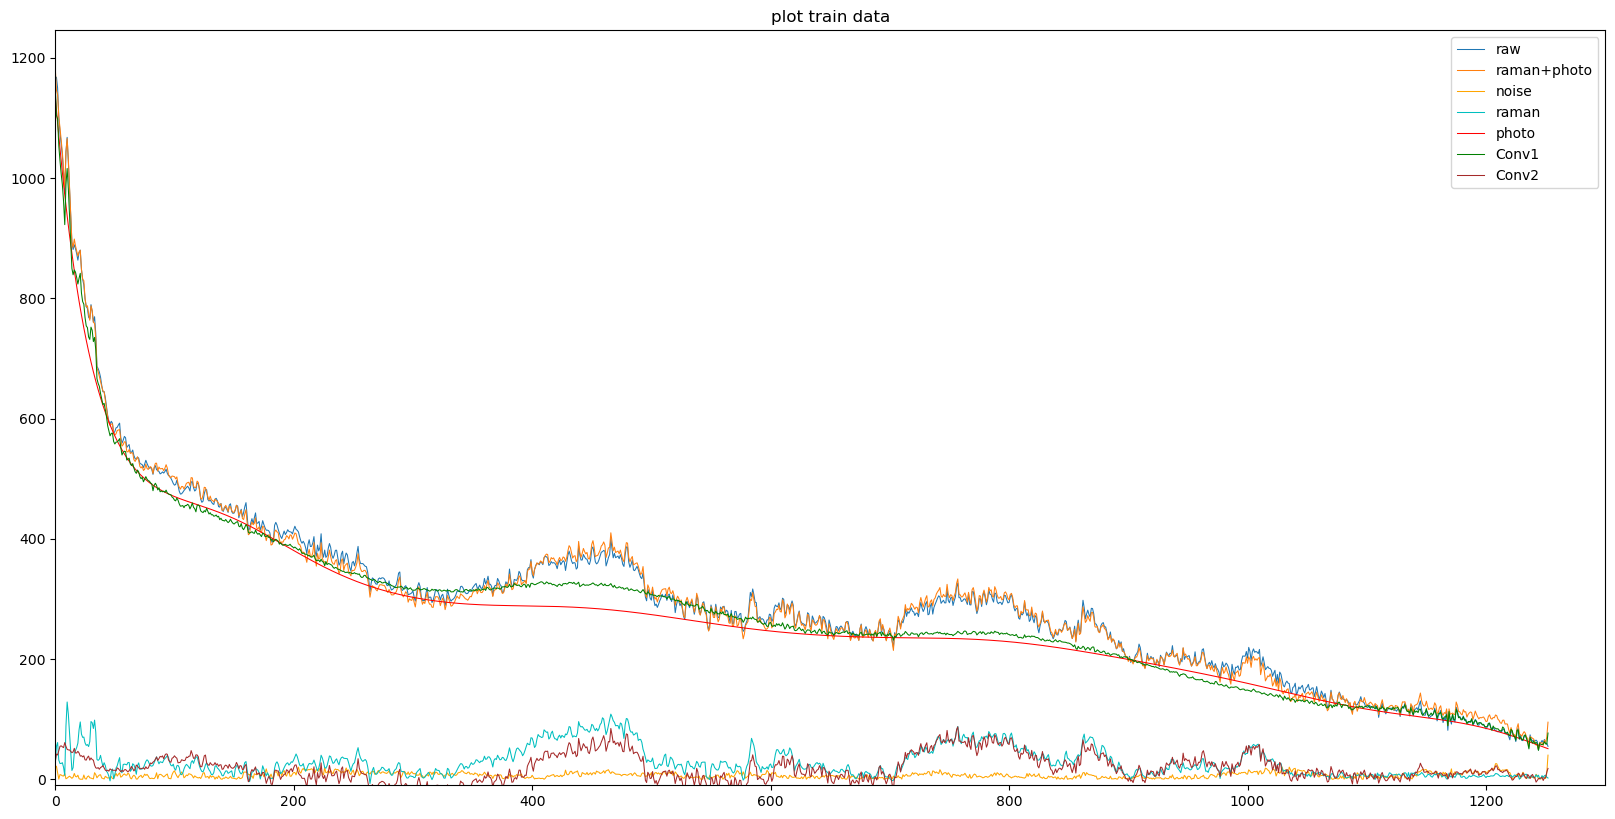

  2022-12-12 12:55:13|   500/ 2696| bits: 0.000727


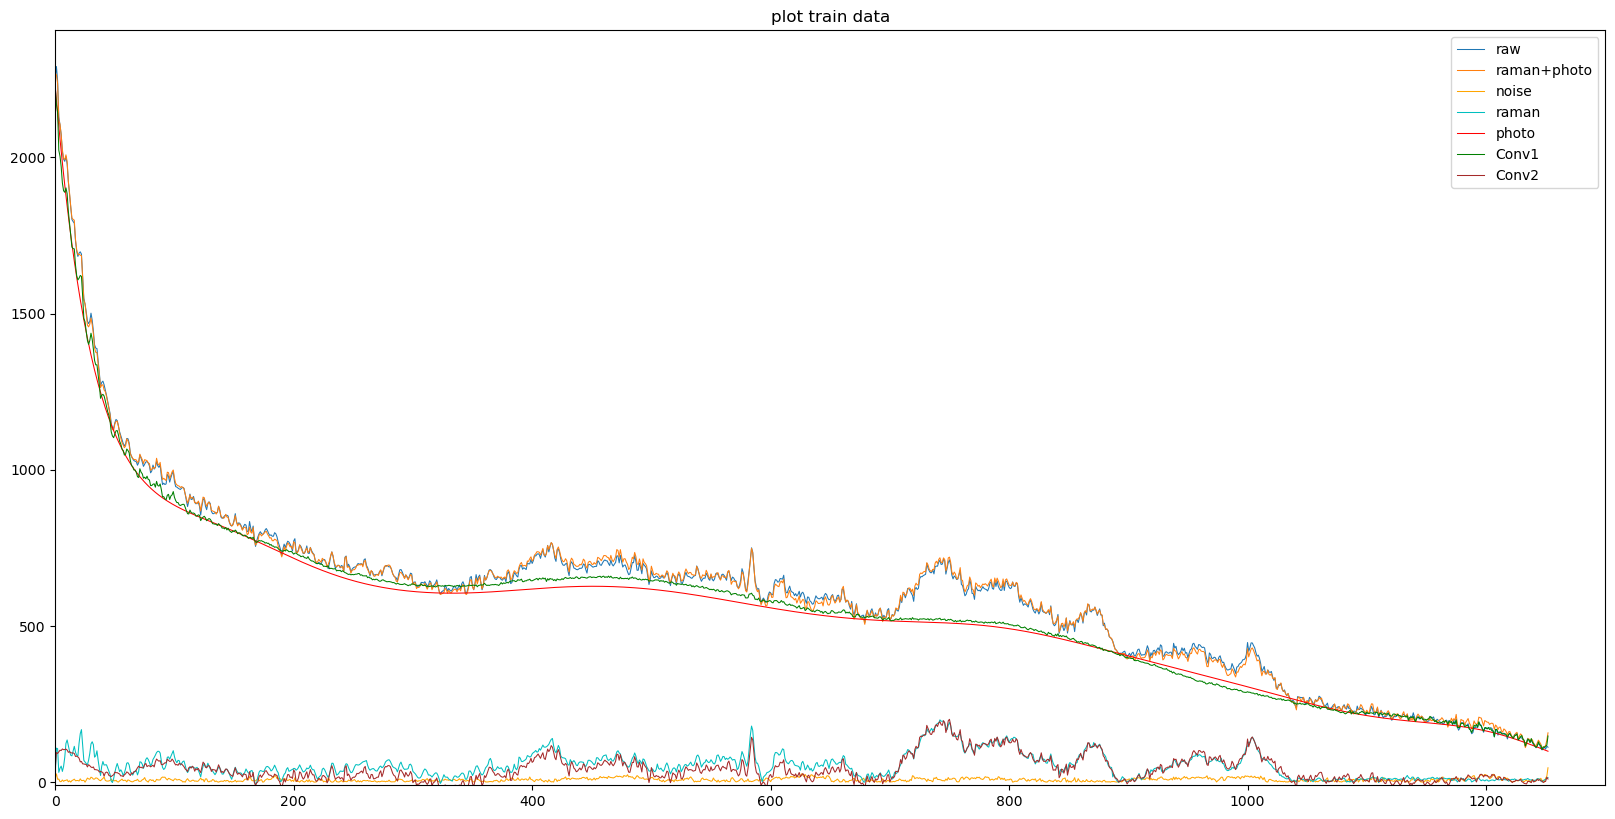

  2022-12-12 12:55:20|  1000/ 2696| bits: 0.000790


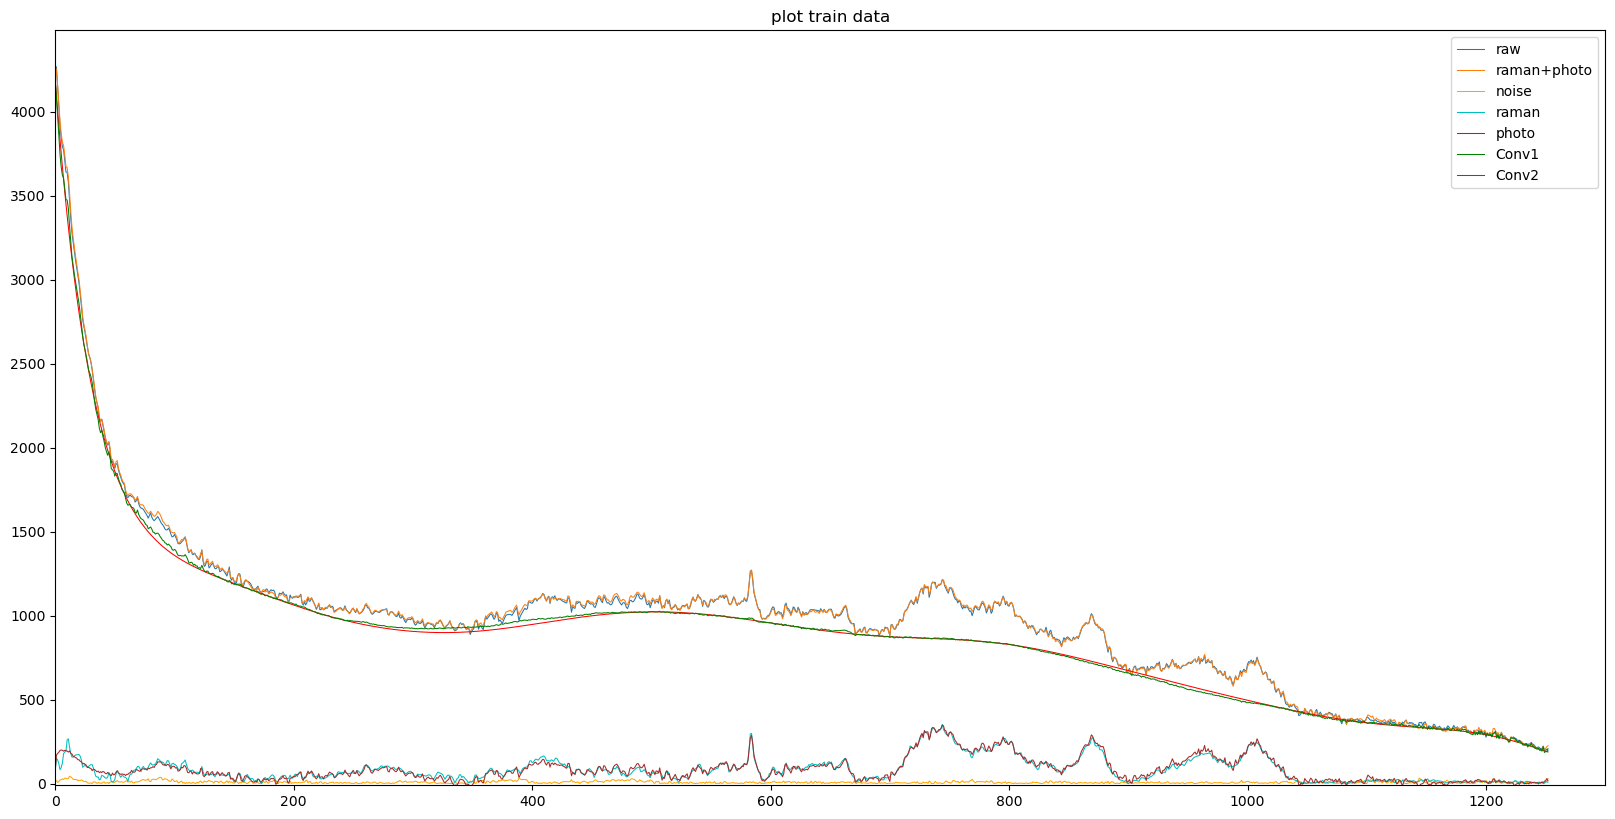

  2022-12-12 12:55:26|  1500/ 2696| bits: 0.000806


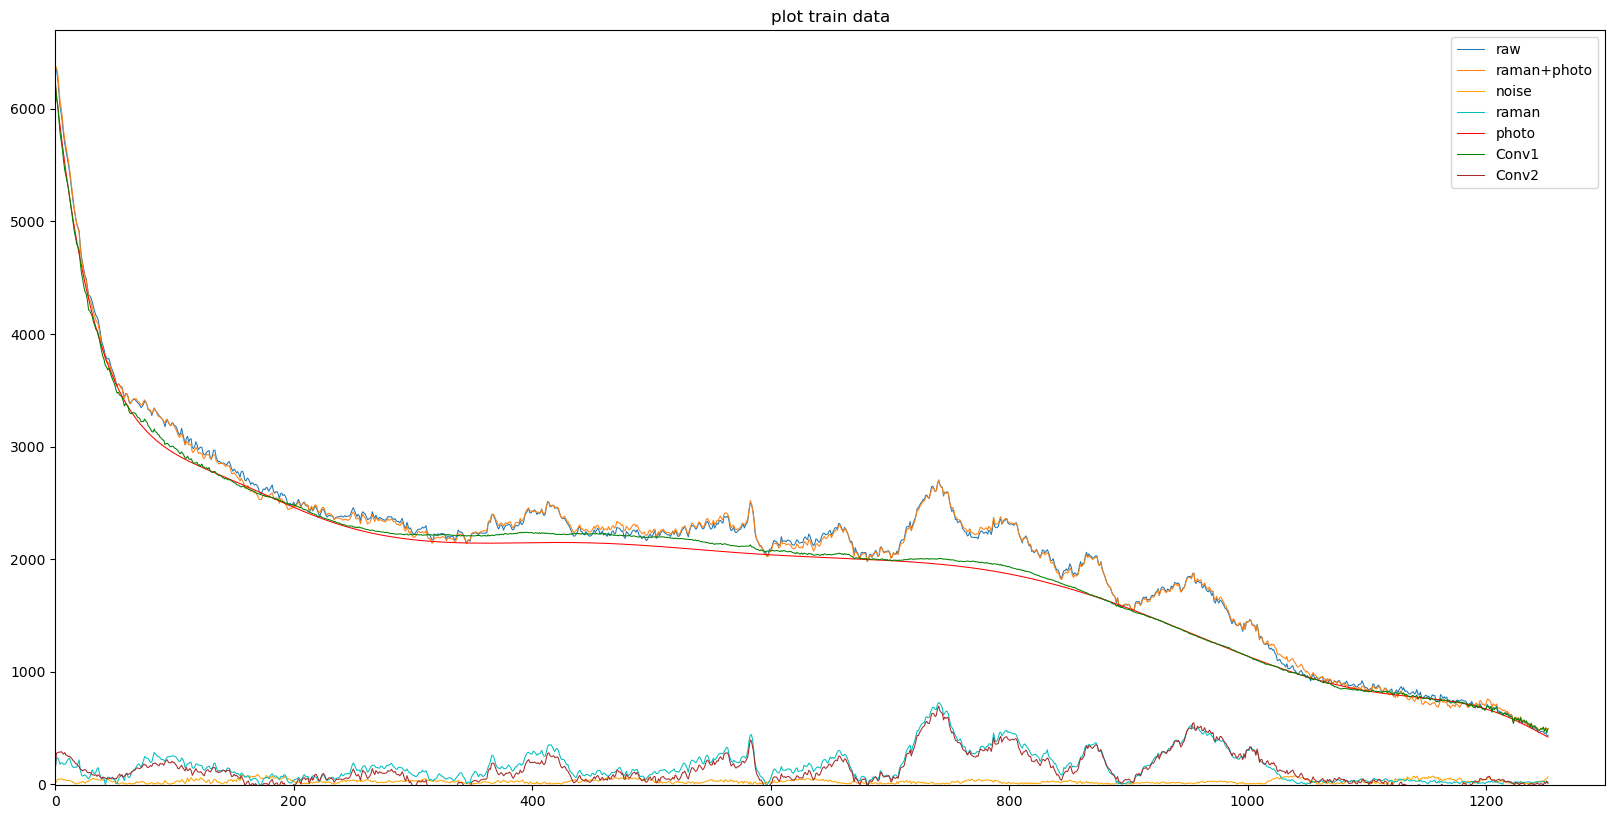

  2022-12-12 12:55:33|  2000/ 2696| bits: 0.000720


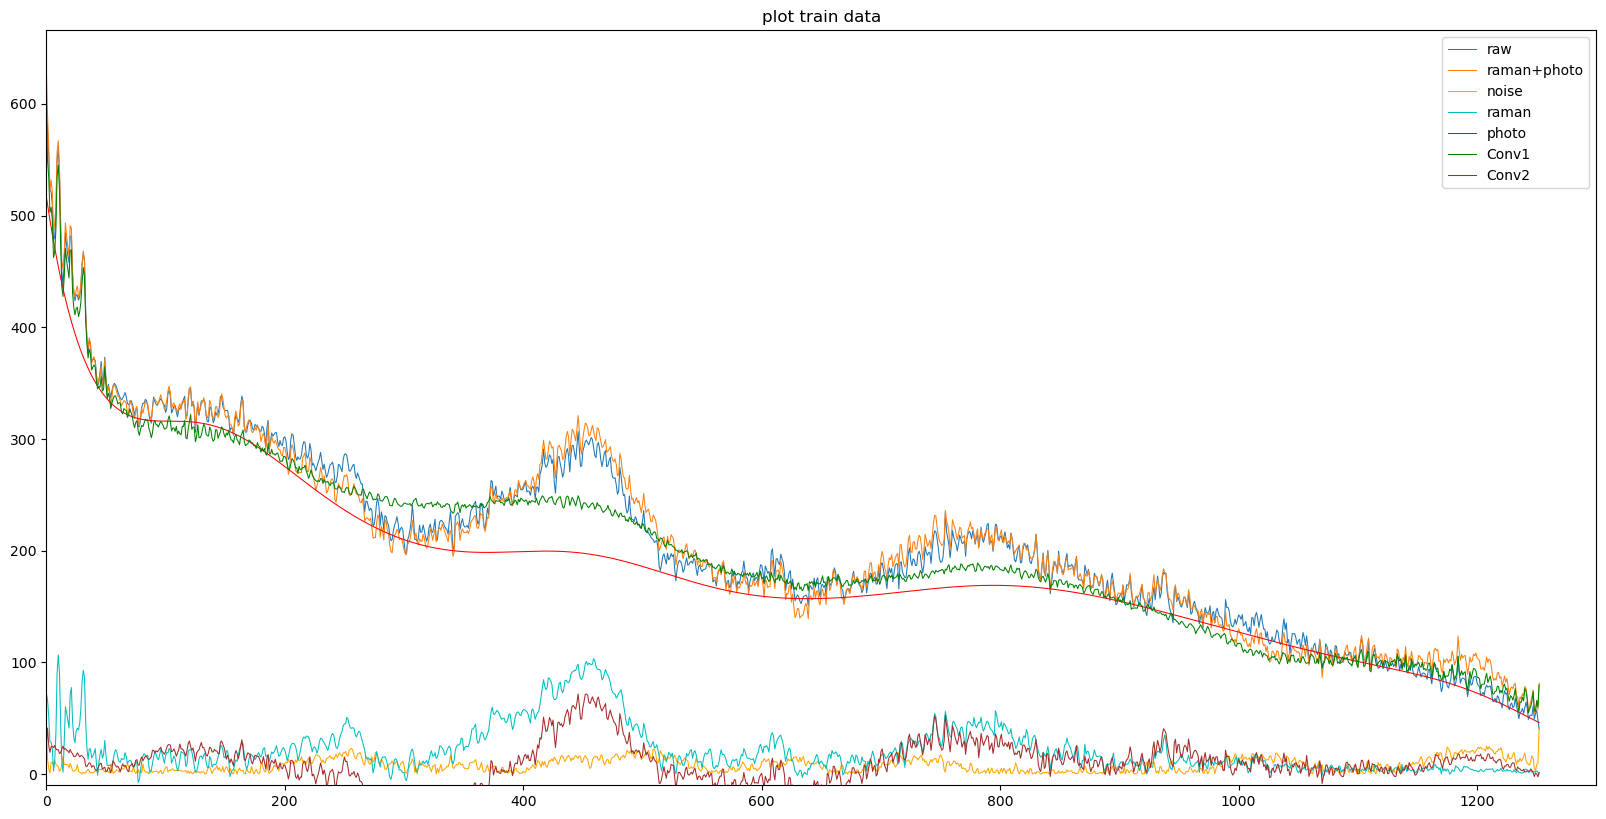

  2022-12-12 12:55:39|  2500/ 2696| bits: 0.000879
Elapsed time: 0h 0m 35s


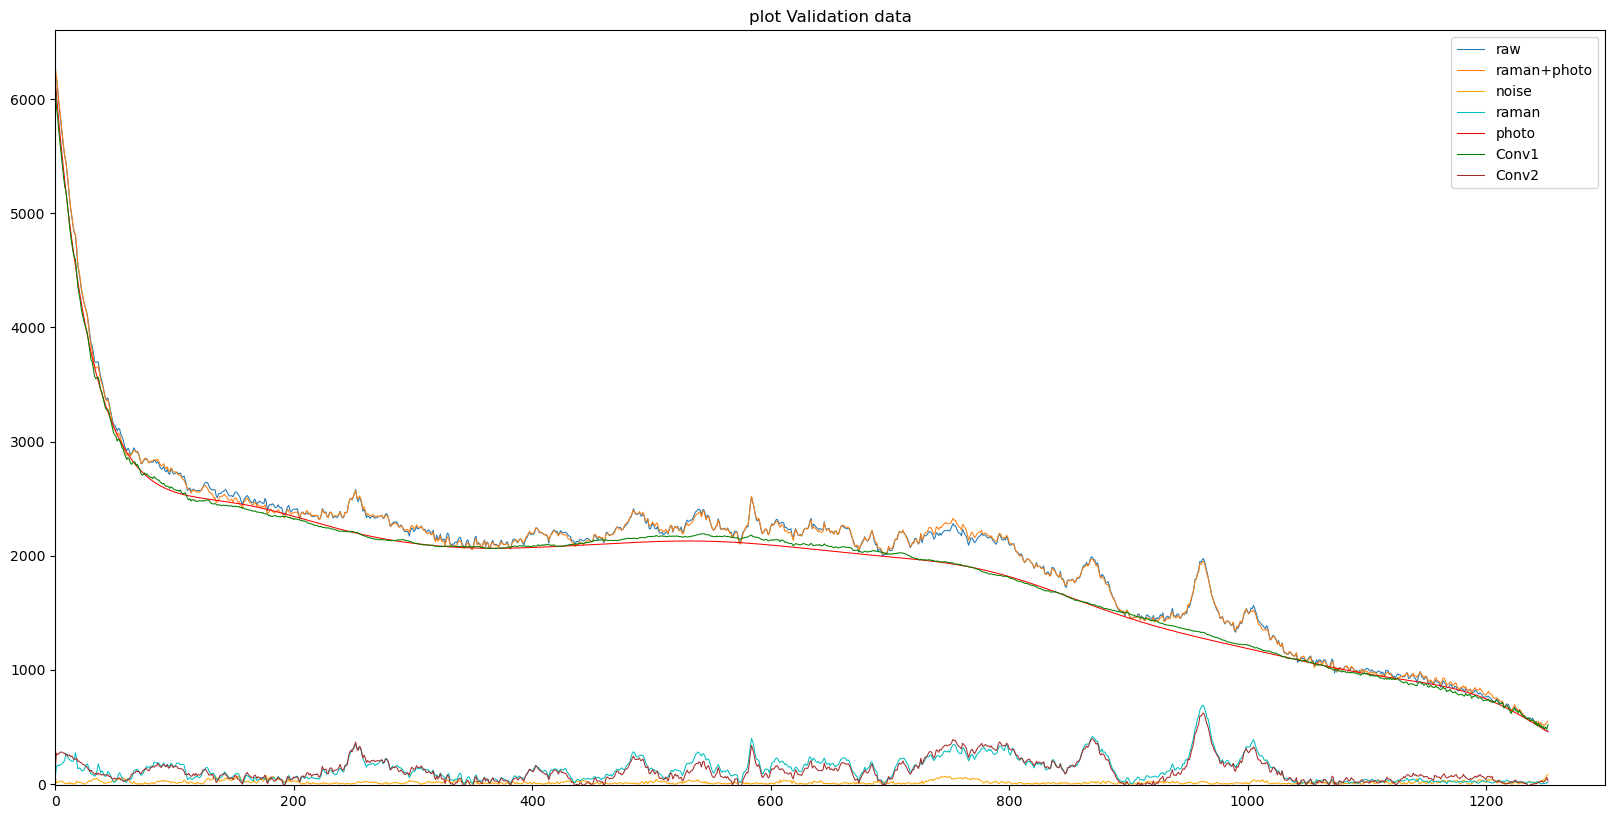

  2022-12-12 12:55:42|     0/  293| bits: 0.000550
Validation average loss: 0.0006764209247194231
--------------------------------------------------
Epoch   4/ 52


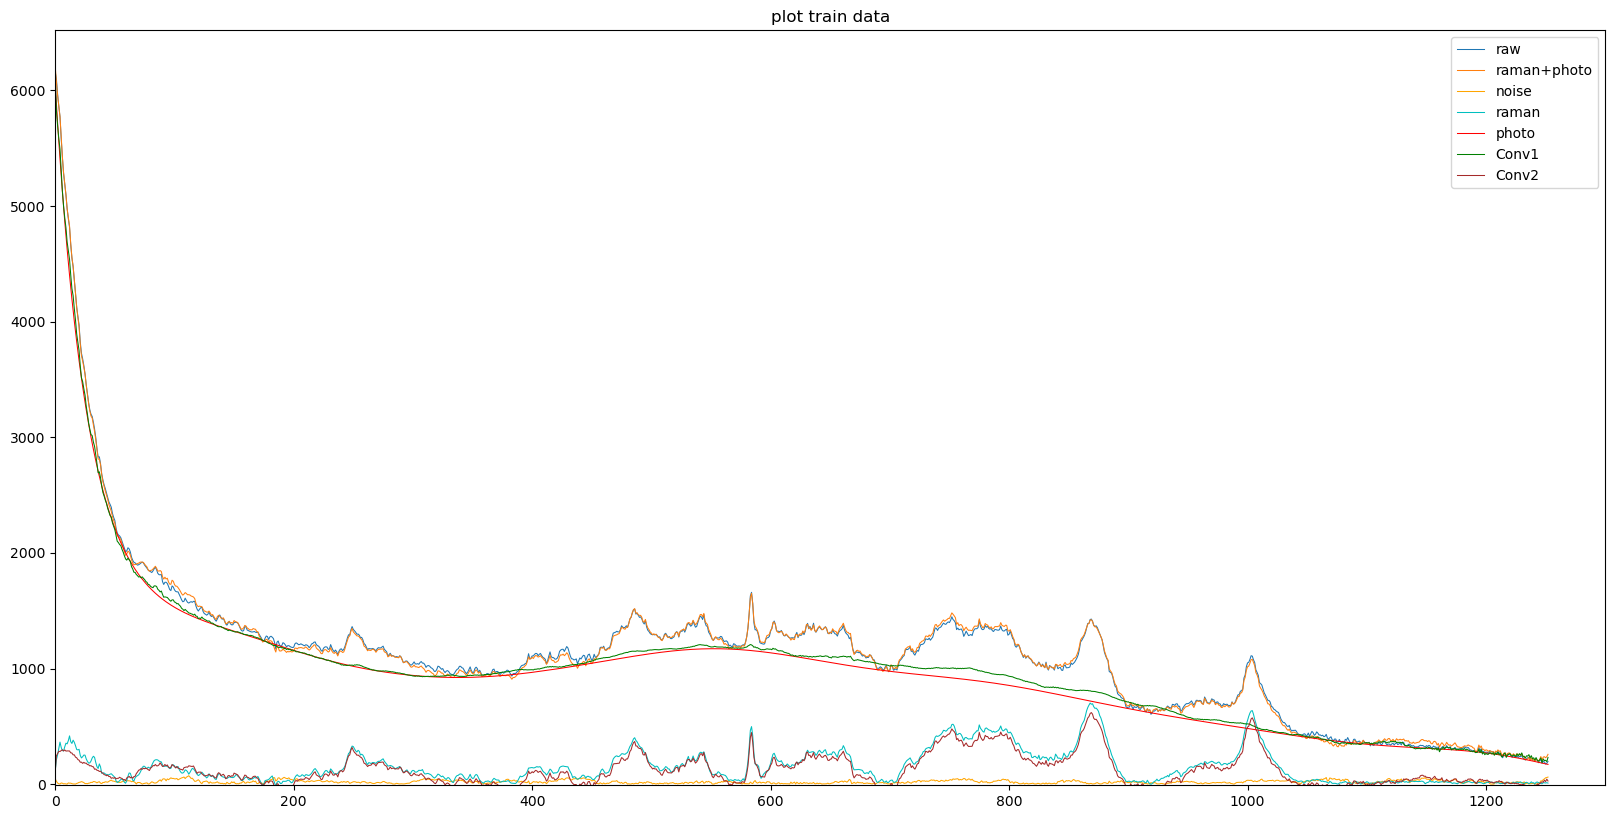

  2022-12-12 12:55:44|     0/ 2696| bits: 0.000728


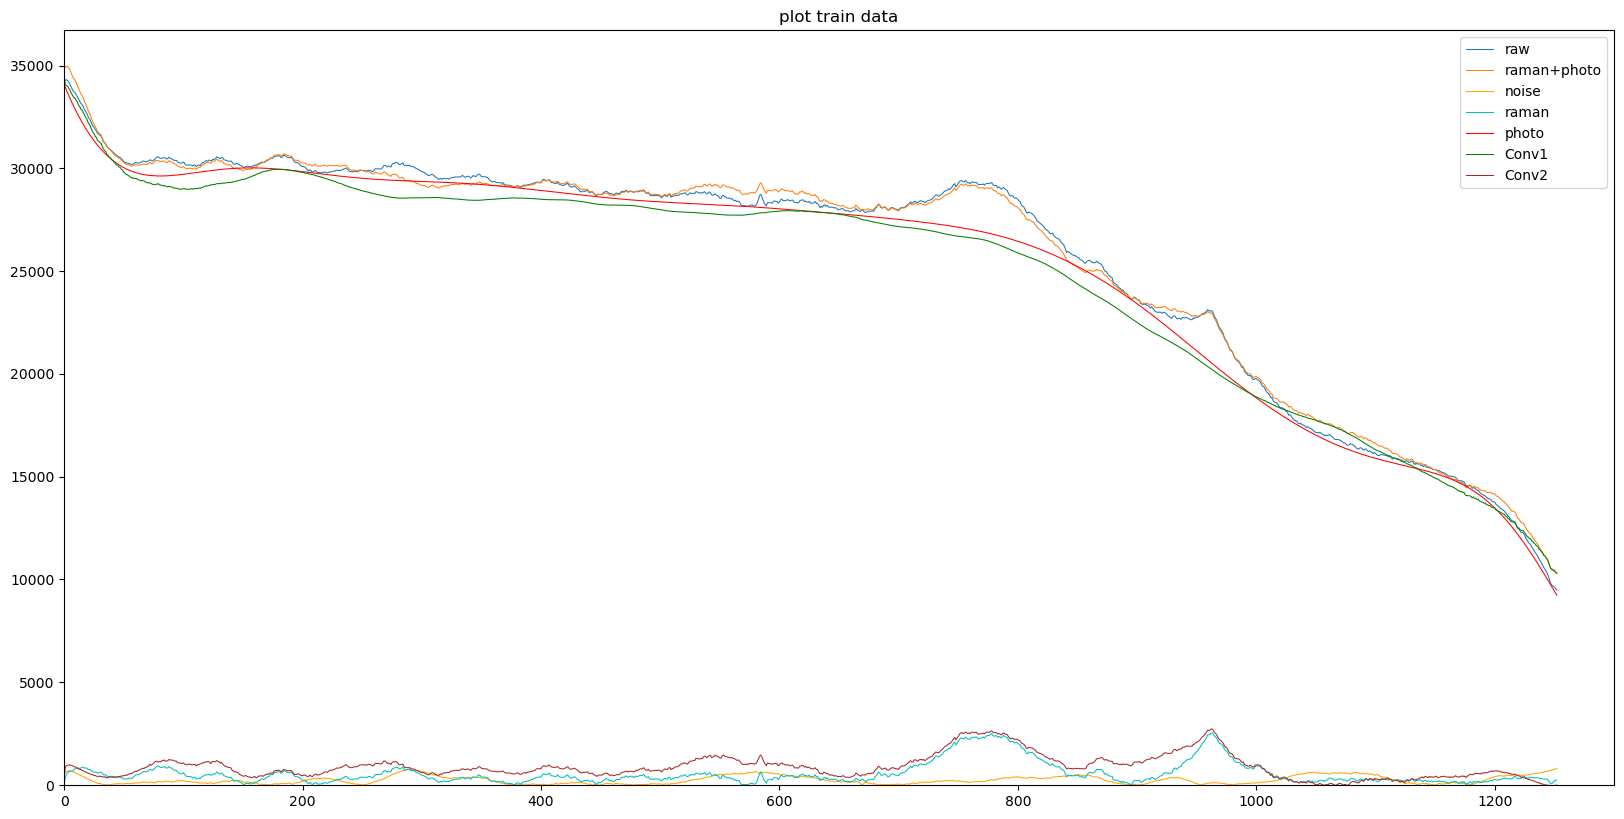

  2022-12-12 12:55:51|   500/ 2696| bits: 0.005050


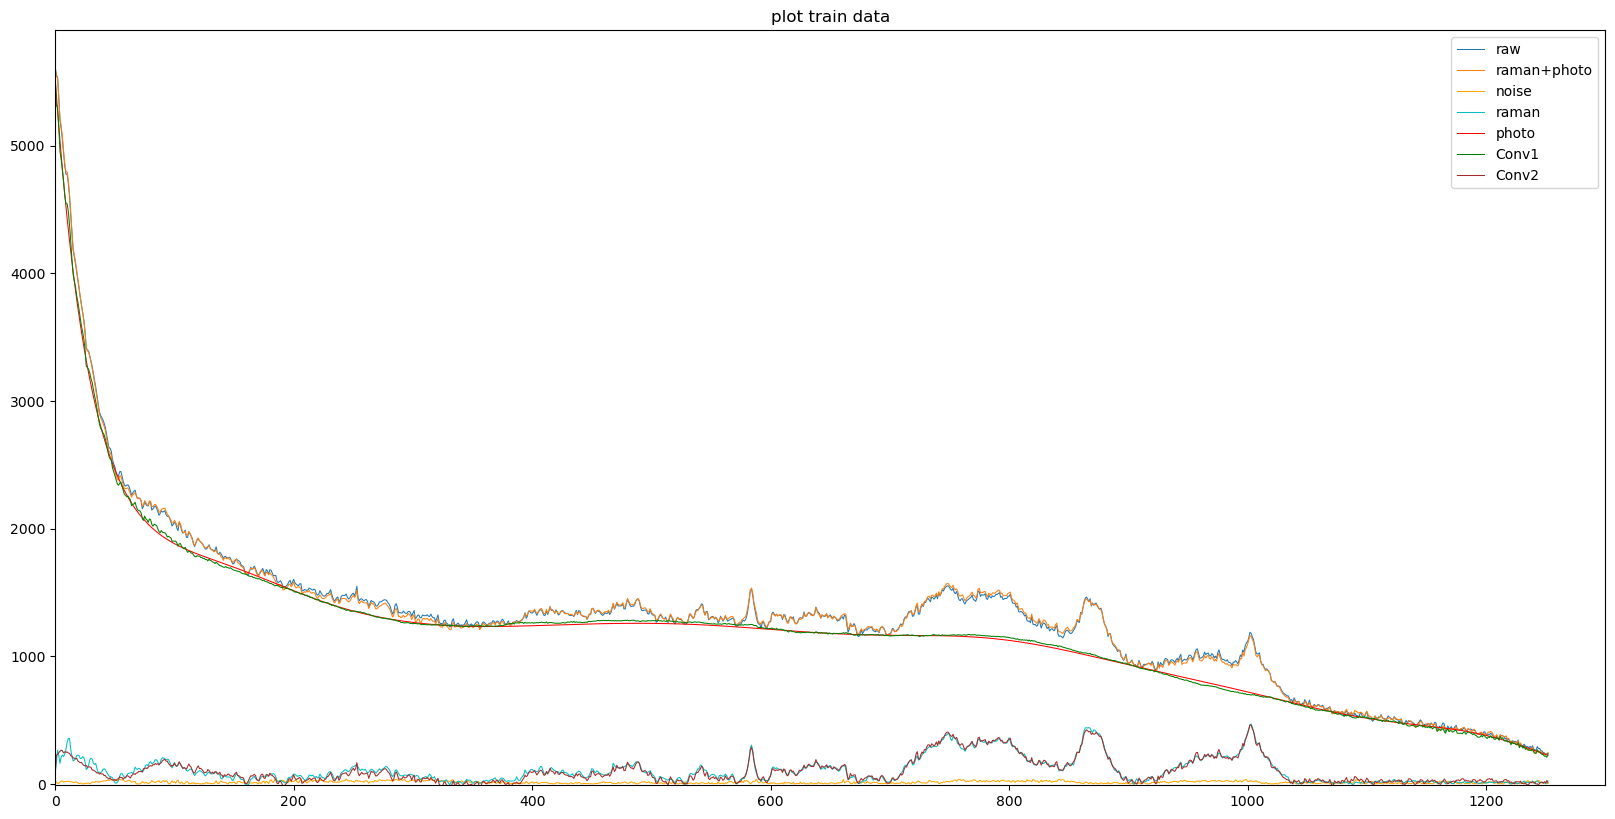

  2022-12-12 12:55:57|  1000/ 2696| bits: 0.000678


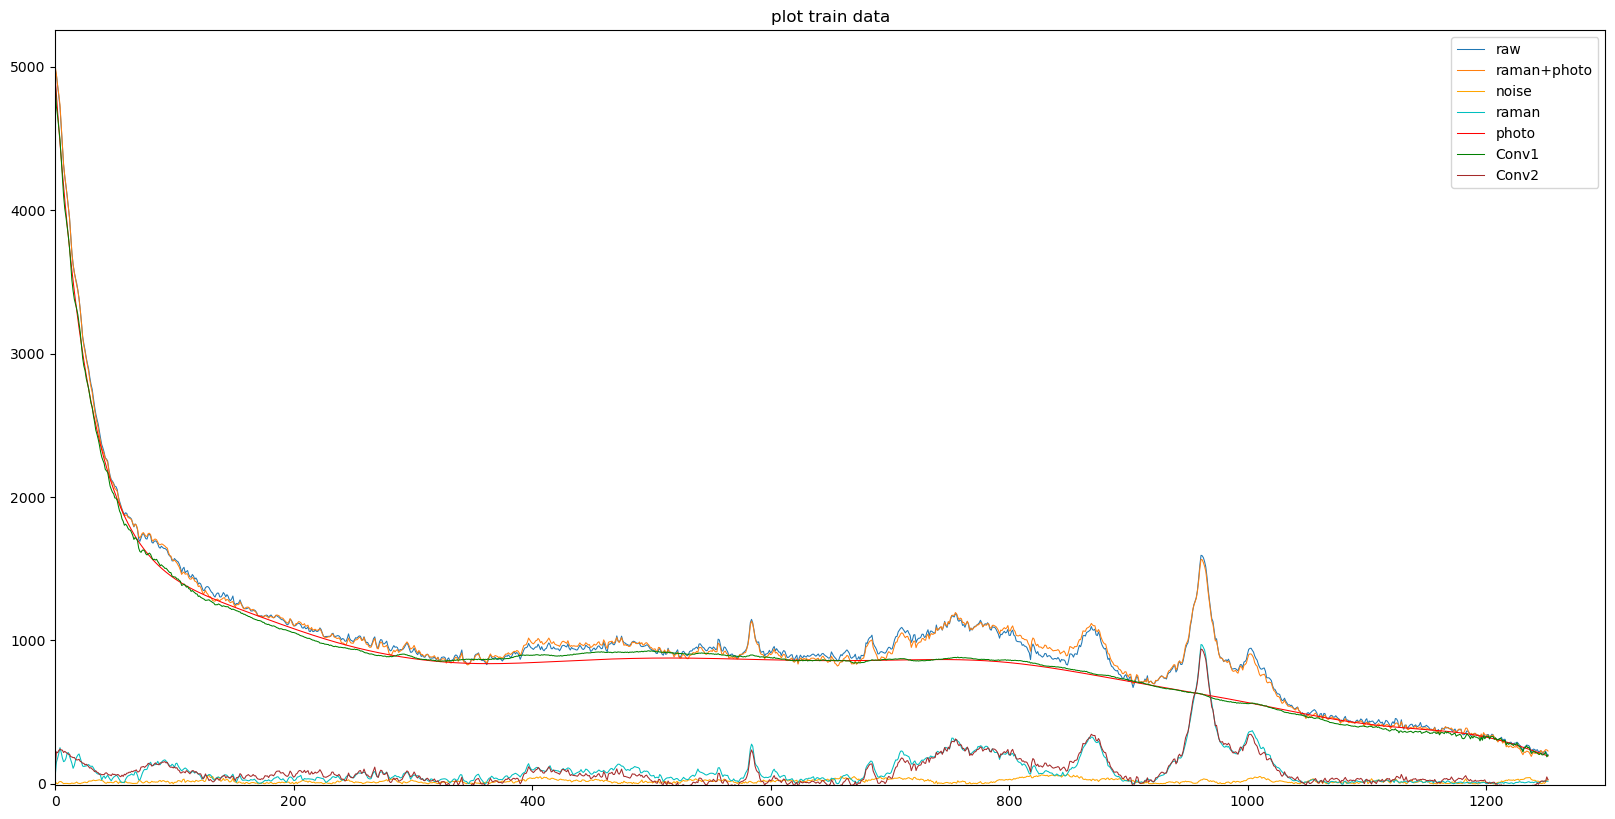

  2022-12-12 12:56:04|  1500/ 2696| bits: 0.000750


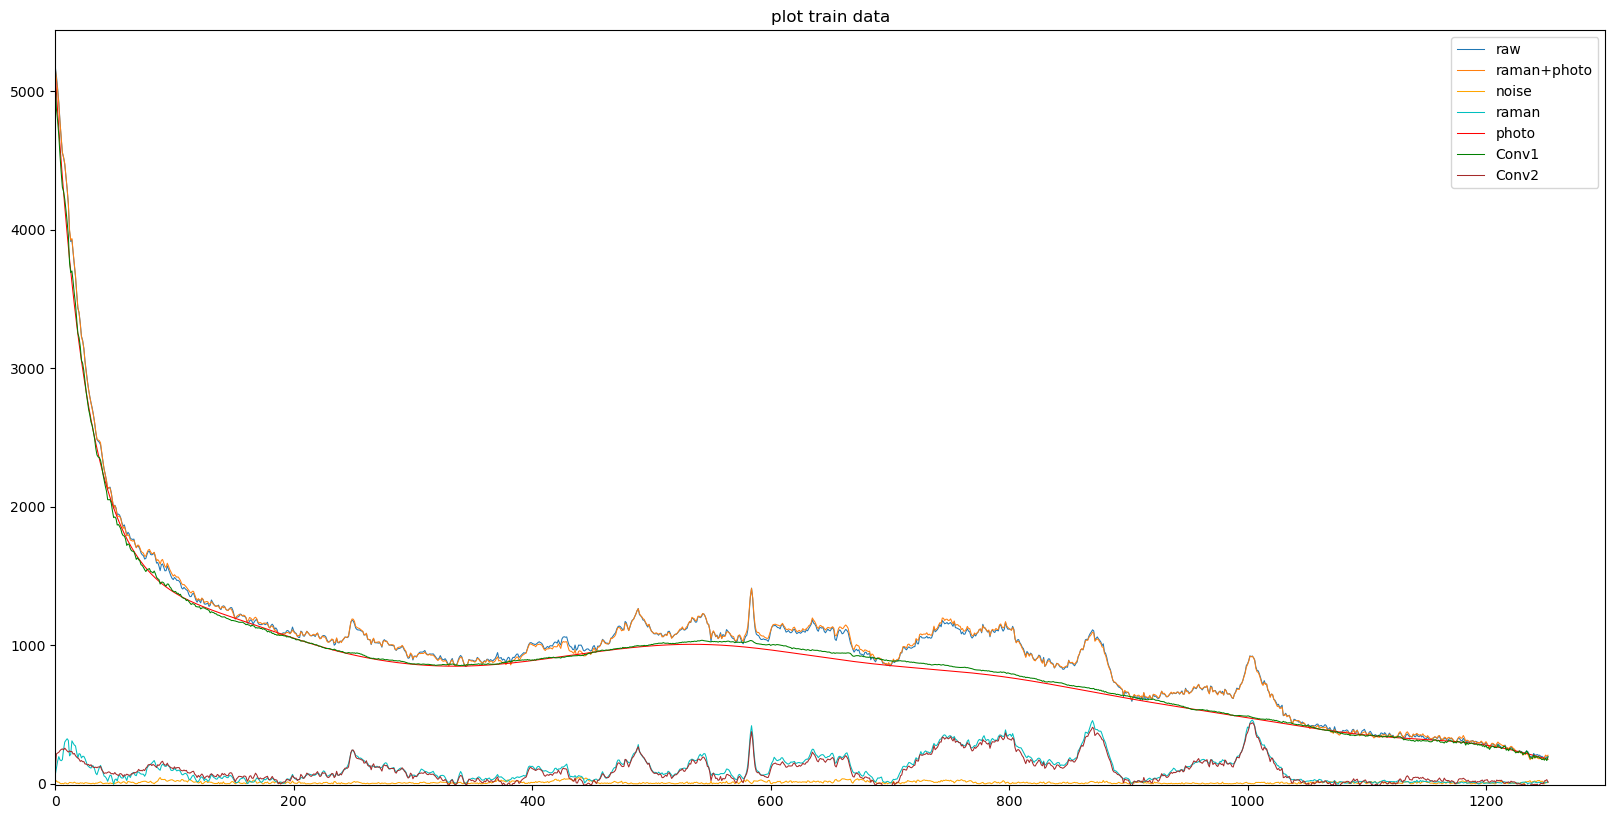

  2022-12-12 12:56:10|  2000/ 2696| bits: 0.000757


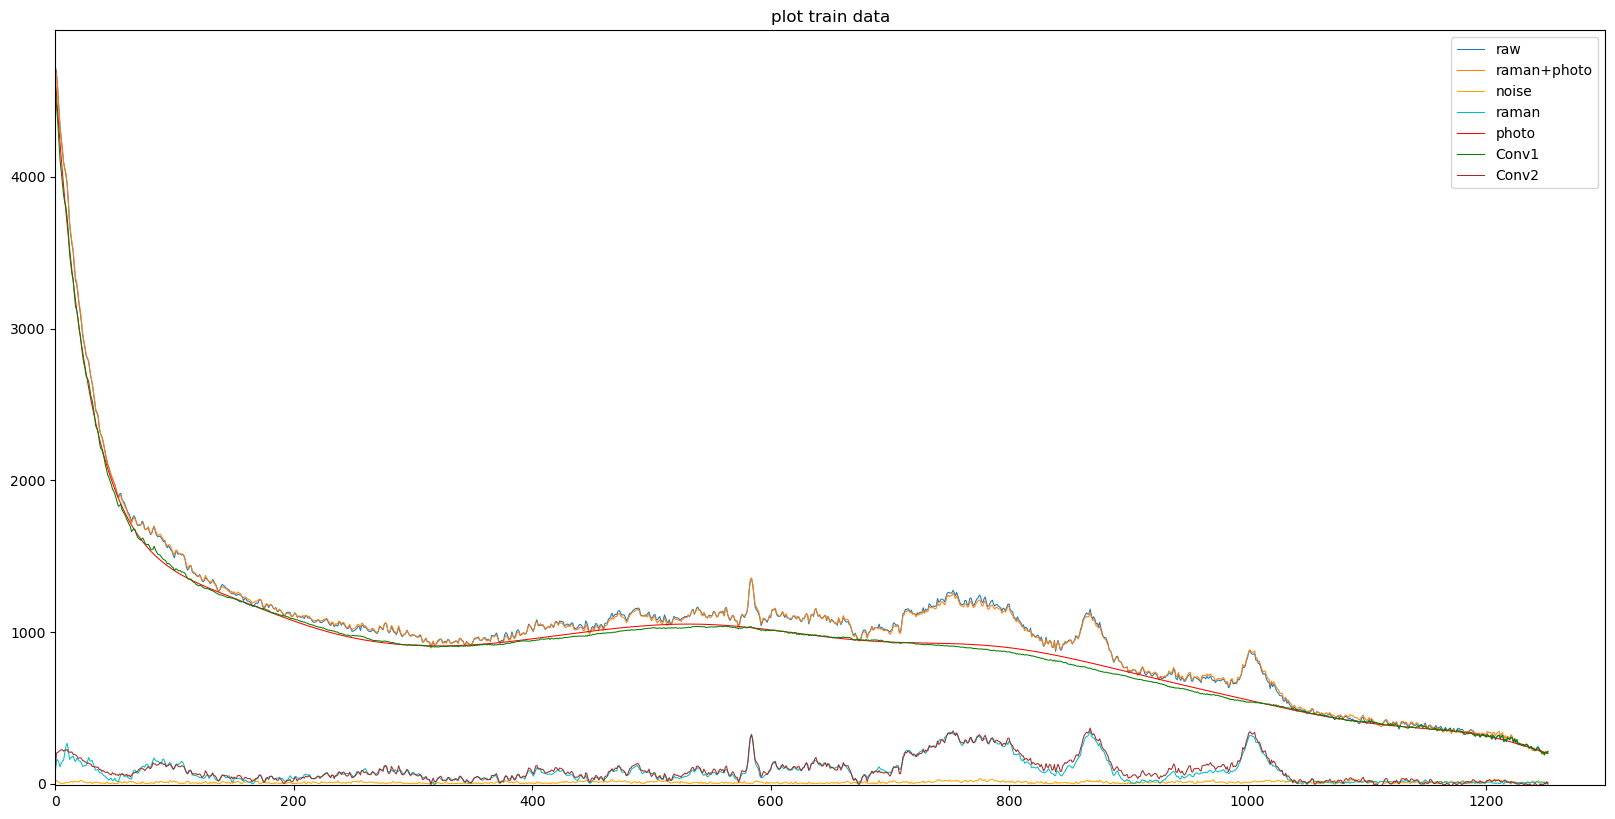

  2022-12-12 12:56:16|  2500/ 2696| bits: 0.001216
Elapsed time: 0h 0m 34s


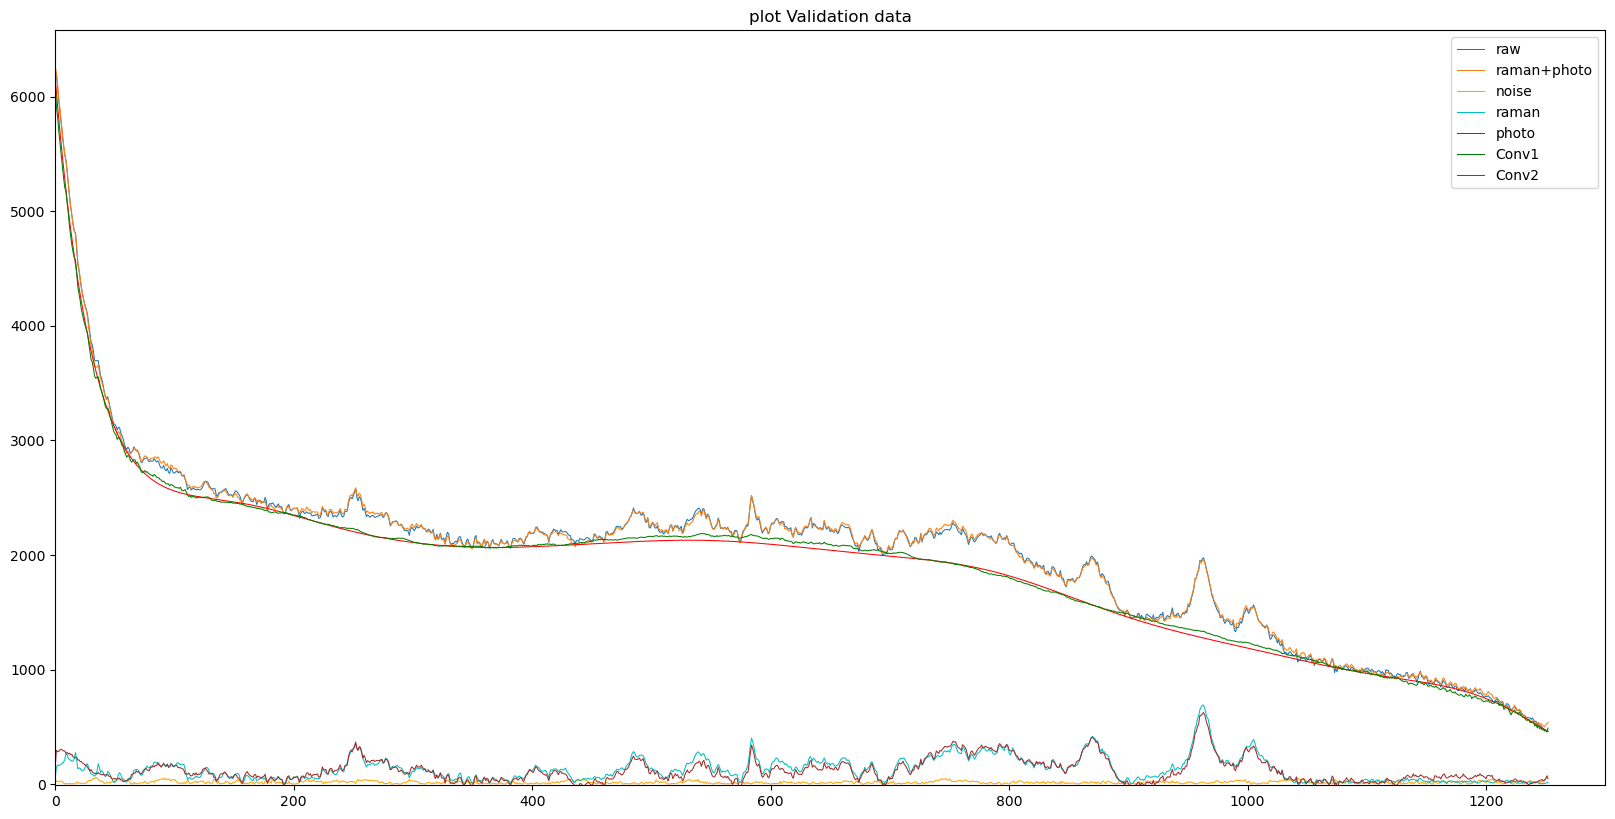

  2022-12-12 12:56:19|     0/  293| bits: 0.000570
Validation average loss: 0.0006553450366482139
--------------------------------------------------
Epoch   5/ 52


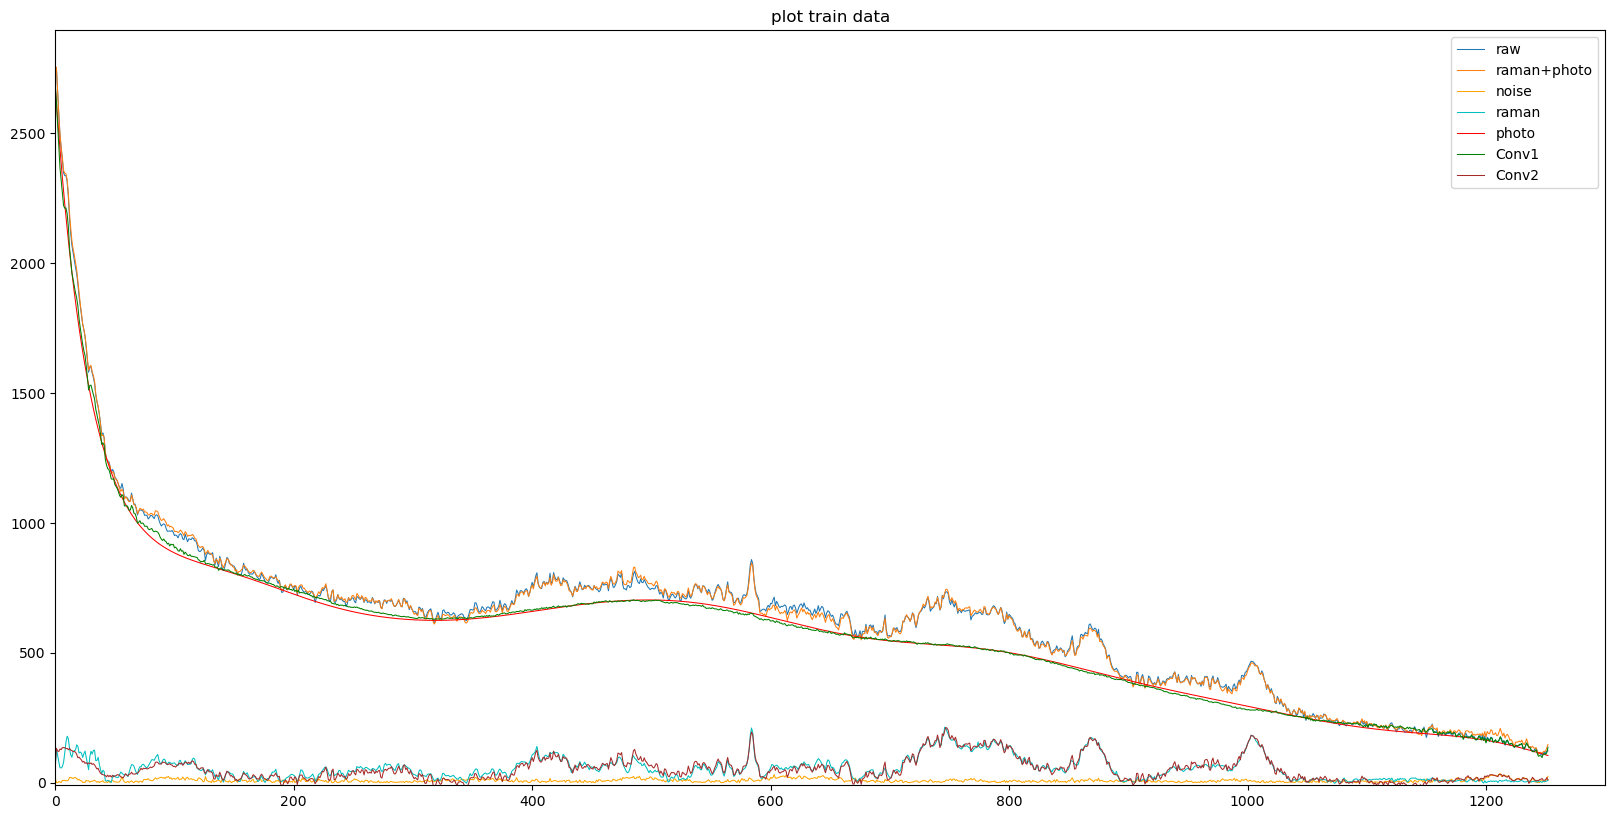

  2022-12-12 12:56:20|     0/ 2696| bits: 0.000733


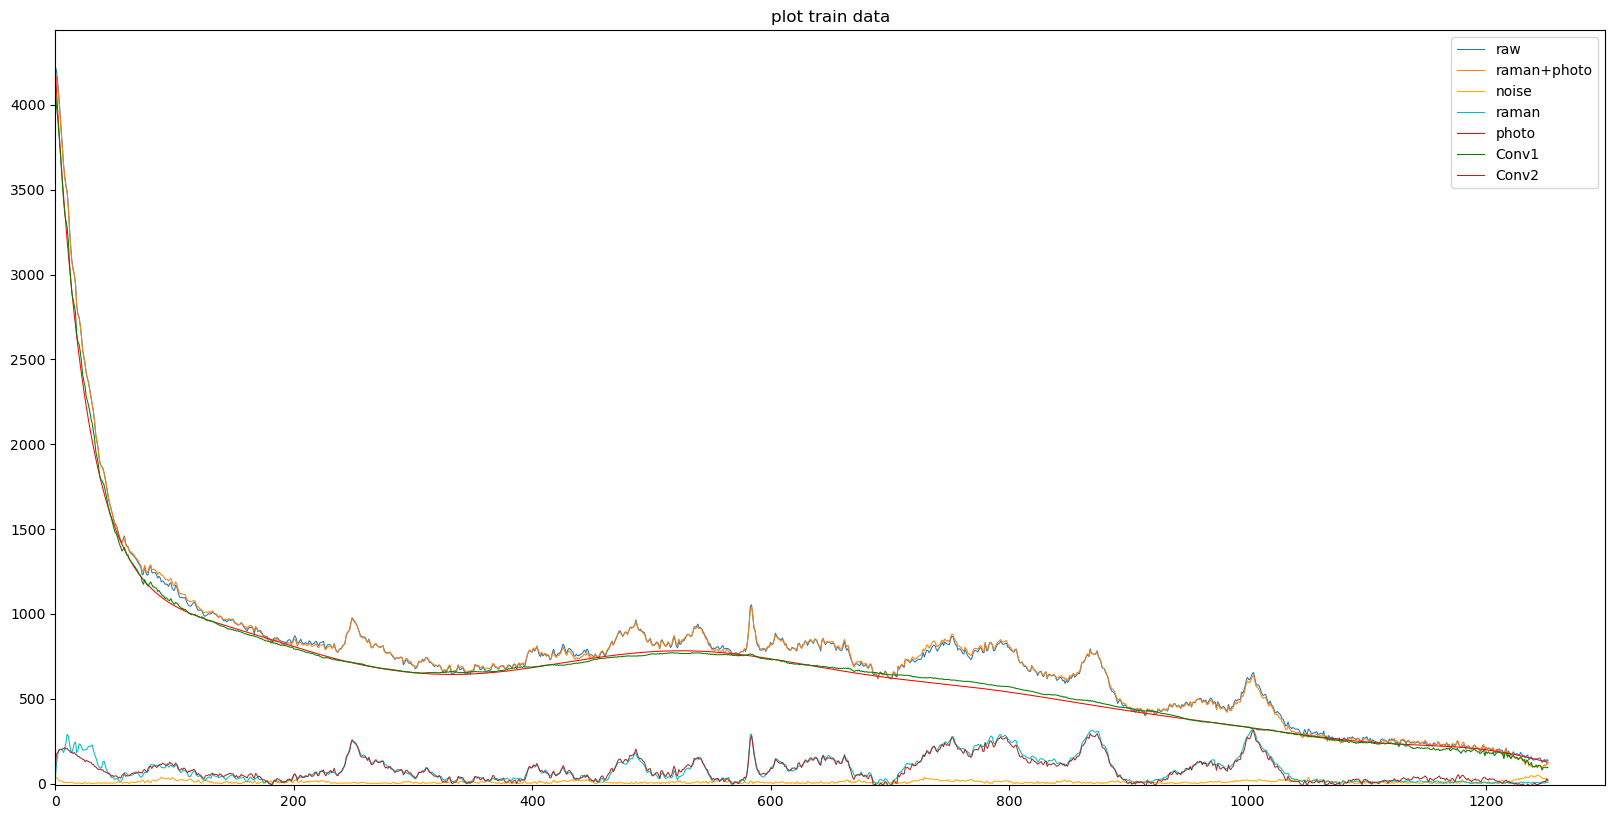

  2022-12-12 12:56:27|   500/ 2696| bits: 0.000647


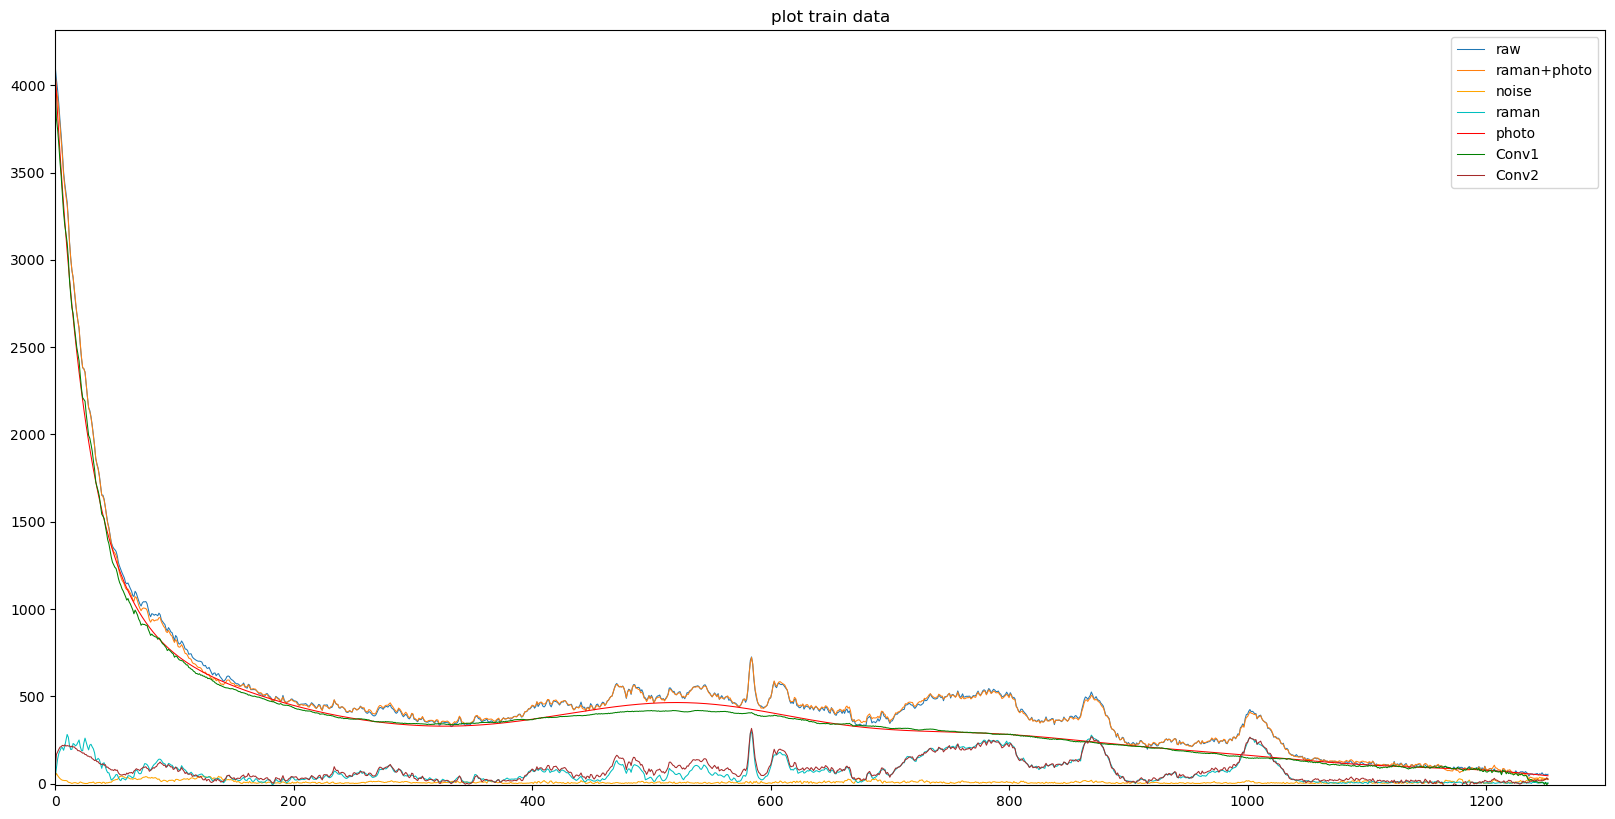

  2022-12-12 12:56:33|  1000/ 2696| bits: 0.000697


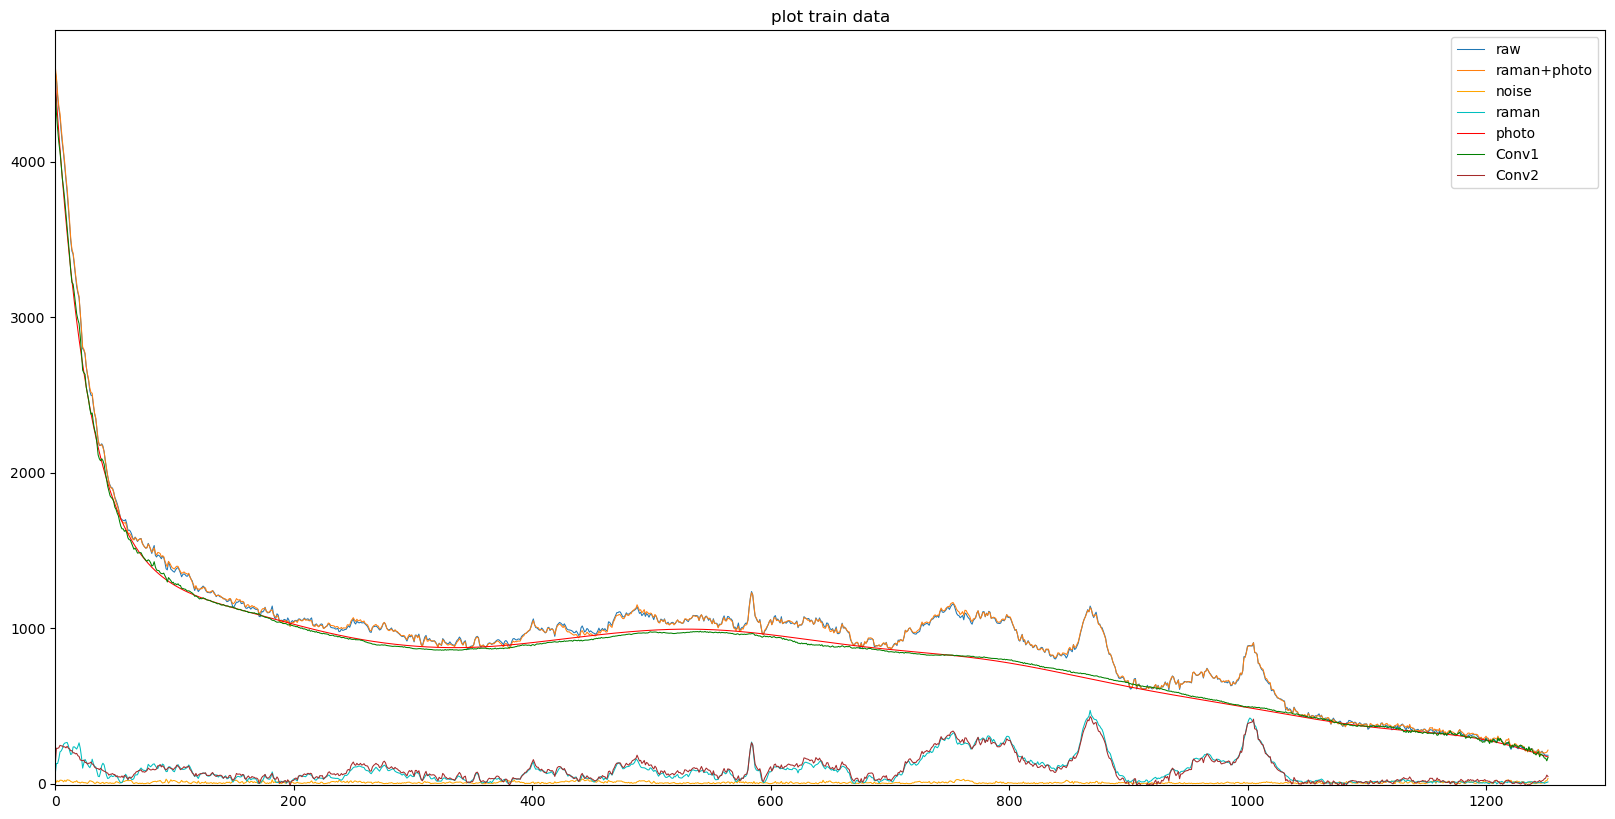

  2022-12-12 12:56:39|  1500/ 2696| bits: 0.000877


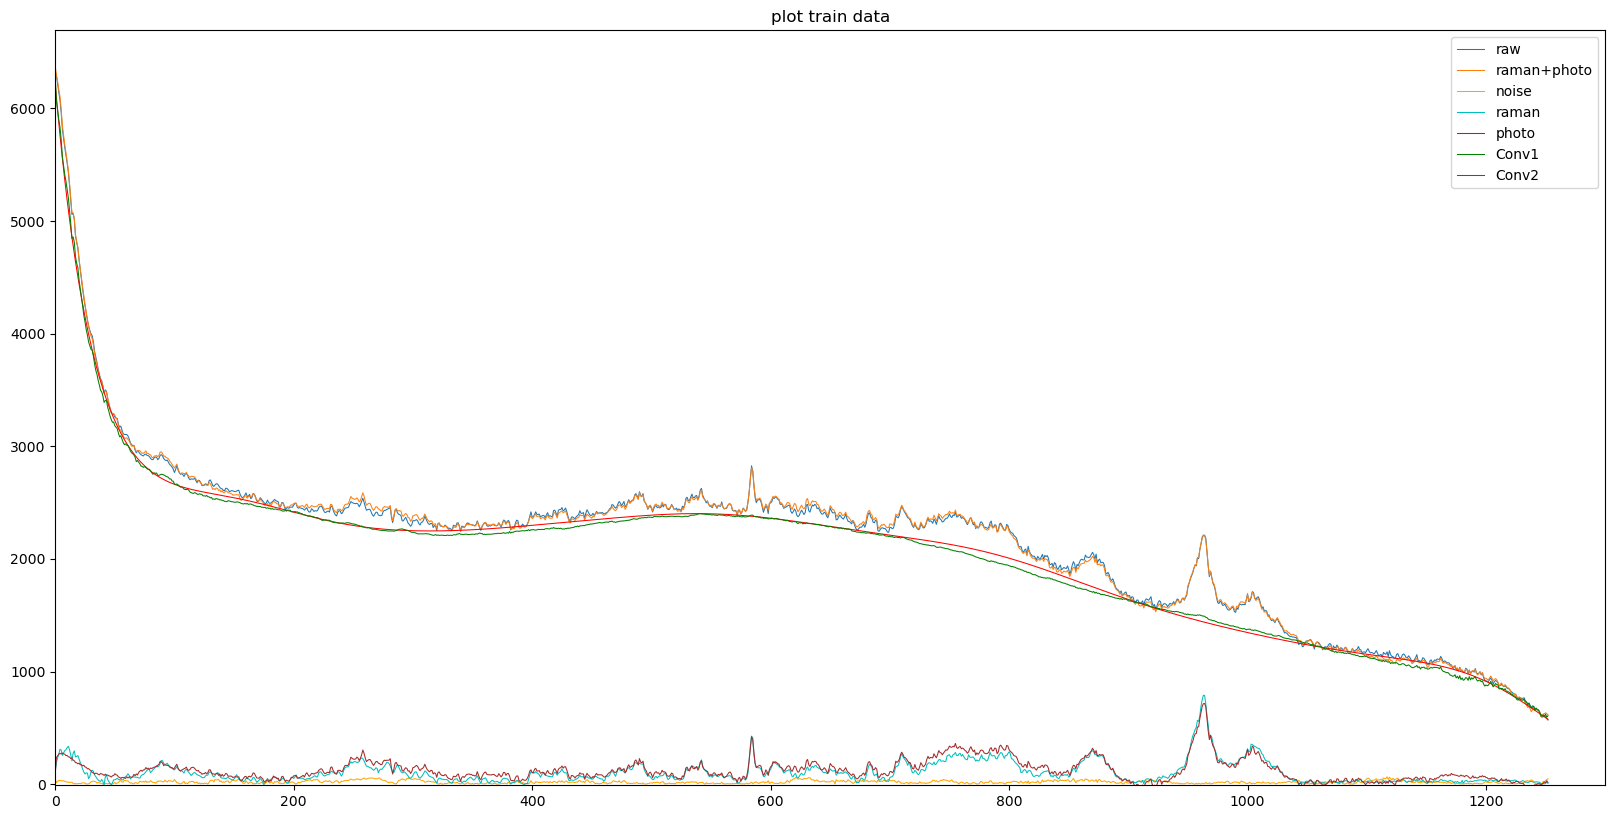

  2022-12-12 12:56:45|  2000/ 2696| bits: 0.000751


In [ ]:
rvc = SupervisedClassifier(**kwargs)
rvc.fit(data)


In [ ]:
# for x, y1, y2, y_1, y_2 in rvc.predict():
#     indices = np.random.choice(BATCH_SIZE, 1, replace=False)
#     for i in indices:
#         plt.plot(x[i], label='raw')
#         plt.plot(y_1[i] + y_2[i], label='raman+photo')
#         plt.plot(y1[i], label='raman')
#         plt.plot(y2[i], label='photo')
#         plt.plot(y_1[i], label='Conv1')
#         plt.plot(y_2[i], label='Conv2')
#         plt.ylim(ymin=-10)
#         plt.xlim(xmin=0, xmax=1300)
#         plt.legend()
#         plt.show()